In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "fsv4"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 287
Categorical features: 6
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 359
Categorical Columns: 6


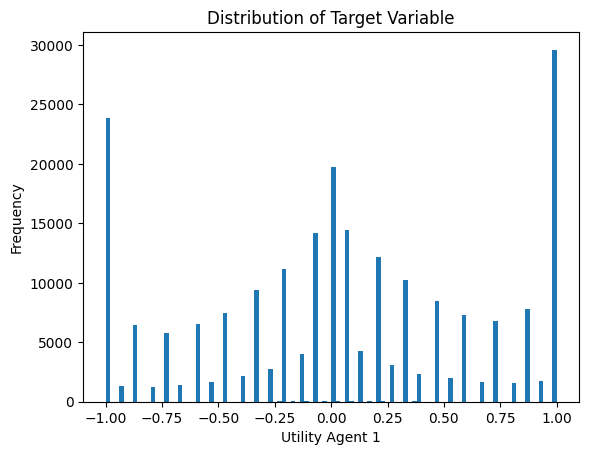

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6131936	test: 0.5457994	best: 0.5457994 (0)	total: 151ms	remaining: 7m 31s


50:	learn: 0.3924953	test: 0.4716829	best: 0.4716829 (50)	total: 4.14s	remaining: 3m 59s


100:	learn: 0.3578739	test: 0.4546038	best: 0.4546038 (100)	total: 8.48s	remaining: 4m 3s


150:	learn: 0.3339327	test: 0.4453363	best: 0.4453363 (150)	total: 12.7s	remaining: 3m 59s


200:	learn: 0.3189844	test: 0.4407071	best: 0.4407071 (200)	total: 16.9s	remaining: 3m 55s


250:	learn: 0.3088406	test: 0.4379704	best: 0.4379524 (249)	total: 21.2s	remaining: 3m 51s


300:	learn: 0.3000666	test: 0.4359175	best: 0.4359175 (300)	total: 25.5s	remaining: 3m 48s


350:	learn: 0.2929561	test: 0.4347408	best: 0.4347408 (350)	total: 29.7s	remaining: 3m 44s


400:	learn: 0.2866806	test: 0.4332656	best: 0.4332447 (399)	total: 33.9s	remaining: 3m 39s


450:	learn: 0.2816730	test: 0.4324378	best: 0.4323658 (445)	total: 38.2s	remaining: 3m 35s


500:	learn: 0.2766294	test: 0.4317952	best: 0.4317952 (500)	total: 42.4s	remaining: 3m 31s


550:	learn: 0.2721166	test: 0.4313192	best: 0.4313192 (550)	total: 46.8s	remaining: 3m 27s


600:	learn: 0.2683456	test: 0.4306928	best: 0.4306928 (600)	total: 51s	remaining: 3m 23s


650:	learn: 0.2644235	test: 0.4302909	best: 0.4302865 (630)	total: 55.3s	remaining: 3m 19s


700:	learn: 0.2607220	test: 0.4298276	best: 0.4298276 (700)	total: 59.6s	remaining: 3m 15s


750:	learn: 0.2574889	test: 0.4295703	best: 0.4295703 (750)	total: 1m 3s	remaining: 3m 11s


800:	learn: 0.2543977	test: 0.4293376	best: 0.4293376 (800)	total: 1m 8s	remaining: 3m 7s


850:	learn: 0.2514876	test: 0.4290353	best: 0.4290353 (850)	total: 1m 12s	remaining: 3m 3s


900:	learn: 0.2486156	test: 0.4285079	best: 0.4285079 (900)	total: 1m 16s	remaining: 2m 59s


950:	learn: 0.2461736	test: 0.4282113	best: 0.4282113 (950)	total: 1m 21s	remaining: 2m 54s


1000:	learn: 0.2435366	test: 0.4278240	best: 0.4278124 (993)	total: 1m 25s	remaining: 2m 50s


1050:	learn: 0.2409718	test: 0.4275127	best: 0.4275125 (1049)	total: 1m 29s	remaining: 2m 46s


1100:	learn: 0.2387267	test: 0.4274250	best: 0.4273943 (1090)	total: 1m 34s	remaining: 2m 42s


1150:	learn: 0.2364545	test: 0.4273355	best: 0.4273303 (1131)	total: 1m 38s	remaining: 2m 38s


1200:	learn: 0.2344450	test: 0.4272135	best: 0.4272067 (1195)	total: 1m 42s	remaining: 2m 33s


1250:	learn: 0.2324304	test: 0.4271252	best: 0.4271045 (1222)	total: 1m 47s	remaining: 2m 29s


1300:	learn: 0.2304578	test: 0.4269882	best: 0.4269771 (1293)	total: 1m 51s	remaining: 2m 25s


1350:	learn: 0.2285101	test: 0.4269636	best: 0.4269250 (1312)	total: 1m 55s	remaining: 2m 21s


1400:	learn: 0.2266250	test: 0.4268609	best: 0.4268456 (1379)	total: 2m	remaining: 2m 16s


1450:	learn: 0.2248716	test: 0.4266324	best: 0.4266324 (1450)	total: 2m 4s	remaining: 2m 12s


1500:	learn: 0.2231847	test: 0.4265027	best: 0.4264902 (1491)	total: 2m 8s	remaining: 2m 8s


1550:	learn: 0.2213862	test: 0.4264050	best: 0.4264050 (1550)	total: 2m 12s	remaining: 2m 4s


1600:	learn: 0.2197290	test: 0.4263066	best: 0.4263062 (1596)	total: 2m 17s	remaining: 1m 59s


1650:	learn: 0.2180567	test: 0.4261766	best: 0.4261682 (1645)	total: 2m 21s	remaining: 1m 55s


1700:	learn: 0.2163893	test: 0.4261126	best: 0.4261019 (1699)	total: 2m 25s	remaining: 1m 51s


1750:	learn: 0.2147682	test: 0.4259838	best: 0.4259838 (1750)	total: 2m 30s	remaining: 1m 47s


1800:	learn: 0.2130771	test: 0.4260133	best: 0.4259838 (1750)	total: 2m 34s	remaining: 1m 43s


1850:	learn: 0.2115933	test: 0.4260115	best: 0.4259740 (1827)	total: 2m 39s	remaining: 1m 38s


1900:	learn: 0.2101748	test: 0.4259403	best: 0.4259403 (1900)	total: 2m 43s	remaining: 1m 34s


1950:	learn: 0.2088277	test: 0.4258518	best: 0.4258484 (1948)	total: 2m 47s	remaining: 1m 30s


2000:	learn: 0.2073900	test: 0.4258092	best: 0.4258039 (1997)	total: 2m 52s	remaining: 1m 25s


2050:	learn: 0.2059534	test: 0.4257344	best: 0.4257304 (2047)	total: 2m 56s	remaining: 1m 21s


2100:	learn: 0.2045490	test: 0.4256150	best: 0.4256070 (2096)	total: 3m	remaining: 1m 17s


2150:	learn: 0.2033854	test: 0.4255810	best: 0.4255712 (2122)	total: 3m 5s	remaining: 1m 13s


2200:	learn: 0.2021662	test: 0.4255250	best: 0.4255250 (2200)	total: 3m 9s	remaining: 1m 8s


2250:	learn: 0.2008158	test: 0.4254627	best: 0.4254577 (2249)	total: 3m 14s	remaining: 1m 4s


2300:	learn: 0.1994937	test: 0.4254184	best: 0.4254184 (2300)	total: 3m 18s	remaining: 1m


2350:	learn: 0.1981501	test: 0.4253794	best: 0.4253696 (2335)	total: 3m 22s	remaining: 55.9s


2400:	learn: 0.1967331	test: 0.4253229	best: 0.4253067 (2395)	total: 3m 26s	remaining: 51.6s


2450:	learn: 0.1954564	test: 0.4252806	best: 0.4252747 (2448)	total: 3m 31s	remaining: 47.3s


2500:	learn: 0.1941788	test: 0.4253427	best: 0.4252747 (2448)	total: 3m 35s	remaining: 43s


2550:	learn: 0.1929818	test: 0.4253292	best: 0.4252747 (2448)	total: 3m 39s	remaining: 38.7s


2600:	learn: 0.1918403	test: 0.4252765	best: 0.4252747 (2448)	total: 3m 44s	remaining: 34.4s


2650:	learn: 0.1906350	test: 0.4252582	best: 0.4252486 (2614)	total: 3m 48s	remaining: 30.1s


2700:	learn: 0.1894309	test: 0.4252313	best: 0.4252046 (2691)	total: 3m 52s	remaining: 25.8s


2750:	learn: 0.1882838	test: 0.4252106	best: 0.4252009 (2746)	total: 3m 57s	remaining: 21.5s


2800:	learn: 0.1871618	test: 0.4251525	best: 0.4251395 (2784)	total: 4m 1s	remaining: 17.2s


2850:	learn: 0.1859999	test: 0.4251982	best: 0.4251395 (2784)	total: 4m 5s	remaining: 12.9s


2900:	learn: 0.1849253	test: 0.4251823	best: 0.4251395 (2784)	total: 4m 10s	remaining: 8.54s


2950:	learn: 0.1838488	test: 0.4251880	best: 0.4251395 (2784)	total: 4m 14s	remaining: 4.23s


2999:	learn: 0.1827514	test: 0.4251660	best: 0.4251395 (2784)	total: 4m 19s	remaining: 0us

bestTest = 0.425139504
bestIteration = 2784

Shrink model to first 2785 iterations.


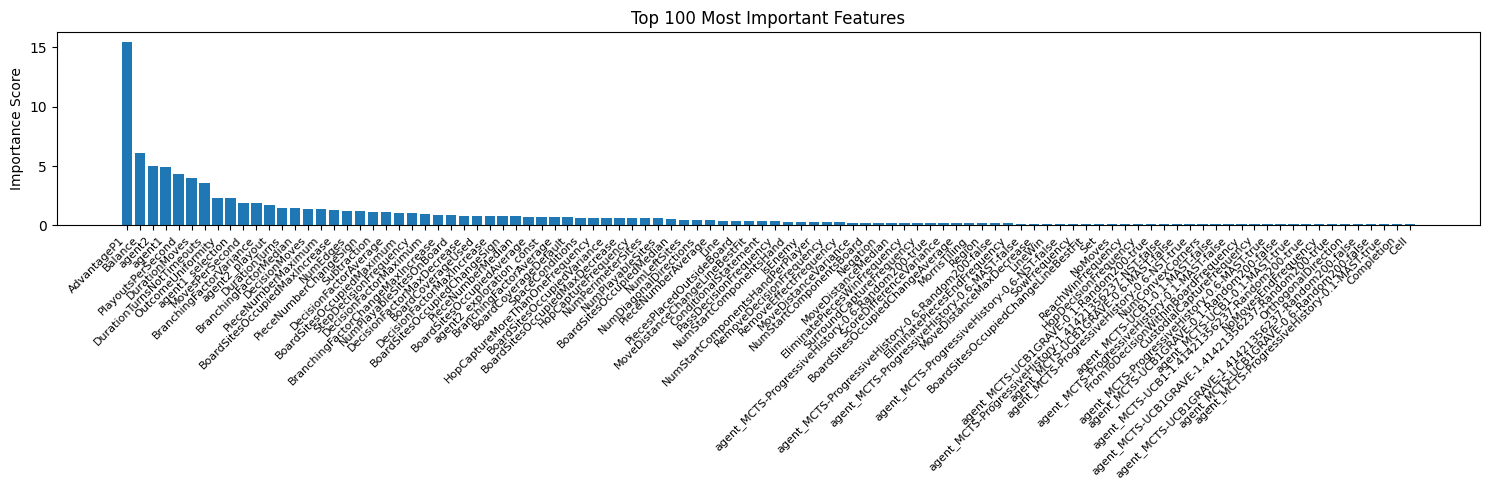

Fold 1 - RMSE: 0.42477071094795166
Fold 2


0:	learn: 0.6067433	test: 0.5822321	best: 0.5822321 (0)	total: 74ms	remaining: 3m 41s


50:	learn: 0.4006454	test: 0.4807889	best: 0.4807889 (50)	total: 4.21s	remaining: 4m 3s


100:	learn: 0.3625680	test: 0.4621399	best: 0.4621399 (100)	total: 8.55s	remaining: 4m 5s


150:	learn: 0.3430131	test: 0.4565416	best: 0.4565416 (150)	total: 12.8s	remaining: 4m 2s


200:	learn: 0.3290125	test: 0.4526393	best: 0.4526393 (200)	total: 17.2s	remaining: 3m 59s


250:	learn: 0.3182255	test: 0.4506015	best: 0.4506015 (250)	total: 21.6s	remaining: 3m 56s


300:	learn: 0.3088754	test: 0.4493300	best: 0.4493255 (298)	total: 25.9s	remaining: 3m 52s


350:	learn: 0.3012802	test: 0.4474829	best: 0.4474271 (349)	total: 30.2s	remaining: 3m 48s


400:	learn: 0.2942130	test: 0.4458155	best: 0.4458155 (400)	total: 34.6s	remaining: 3m 43s


450:	learn: 0.2887822	test: 0.4450105	best: 0.4449818 (447)	total: 38.9s	remaining: 3m 40s


500:	learn: 0.2838543	test: 0.4447243	best: 0.4446535 (485)	total: 43.5s	remaining: 3m 36s


550:	learn: 0.2795142	test: 0.4443696	best: 0.4443372 (548)	total: 47.9s	remaining: 3m 32s


600:	learn: 0.2753840	test: 0.4437916	best: 0.4437845 (598)	total: 52.3s	remaining: 3m 28s


650:	learn: 0.2717217	test: 0.4429061	best: 0.4428870 (647)	total: 56.8s	remaining: 3m 24s


700:	learn: 0.2680952	test: 0.4426464	best: 0.4426464 (700)	total: 1m 1s	remaining: 3m 20s


750:	learn: 0.2647456	test: 0.4423458	best: 0.4423458 (750)	total: 1m 5s	remaining: 3m 16s


800:	learn: 0.2614111	test: 0.4422078	best: 0.4421927 (799)	total: 1m 10s	remaining: 3m 12s


850:	learn: 0.2583933	test: 0.4423159	best: 0.4421927 (799)	total: 1m 14s	remaining: 3m 8s


900:	learn: 0.2557399	test: 0.4421318	best: 0.4421215 (896)	total: 1m 19s	remaining: 3m 4s


950:	learn: 0.2530022	test: 0.4419658	best: 0.4419658 (950)	total: 1m 23s	remaining: 3m


1000:	learn: 0.2504573	test: 0.4416858	best: 0.4416858 (1000)	total: 1m 28s	remaining: 2m 56s


1050:	learn: 0.2480655	test: 0.4414024	best: 0.4414024 (1050)	total: 1m 32s	remaining: 2m 51s


1100:	learn: 0.2458674	test: 0.4412661	best: 0.4412523 (1099)	total: 1m 37s	remaining: 2m 47s


1150:	learn: 0.2437938	test: 0.4410740	best: 0.4410740 (1150)	total: 1m 41s	remaining: 2m 43s


1200:	learn: 0.2415729	test: 0.4409331	best: 0.4409249 (1191)	total: 1m 46s	remaining: 2m 39s


1250:	learn: 0.2394384	test: 0.4408560	best: 0.4408338 (1229)	total: 1m 50s	remaining: 2m 34s


1300:	learn: 0.2374880	test: 0.4408533	best: 0.4407400 (1289)	total: 1m 55s	remaining: 2m 30s


1350:	learn: 0.2356313	test: 0.4407621	best: 0.4407400 (1289)	total: 1m 59s	remaining: 2m 26s


1400:	learn: 0.2337387	test: 0.4406292	best: 0.4406141 (1397)	total: 2m 4s	remaining: 2m 21s


1450:	learn: 0.2318713	test: 0.4404516	best: 0.4404516 (1450)	total: 2m 8s	remaining: 2m 17s


1500:	learn: 0.2300174	test: 0.4402349	best: 0.4402349 (1500)	total: 2m 13s	remaining: 2m 13s


1550:	learn: 0.2281258	test: 0.4399327	best: 0.4399327 (1550)	total: 2m 18s	remaining: 2m 9s


1600:	learn: 0.2264284	test: 0.4397766	best: 0.4397551 (1595)	total: 2m 22s	remaining: 2m 4s


1650:	learn: 0.2247772	test: 0.4397346	best: 0.4397220 (1647)	total: 2m 27s	remaining: 2m


1700:	learn: 0.2230527	test: 0.4396638	best: 0.4396266 (1691)	total: 2m 31s	remaining: 1m 55s


1750:	learn: 0.2213749	test: 0.4396032	best: 0.4395960 (1739)	total: 2m 36s	remaining: 1m 51s


1800:	learn: 0.2198401	test: 0.4395063	best: 0.4394927 (1794)	total: 2m 40s	remaining: 1m 47s


1850:	learn: 0.2182132	test: 0.4393238	best: 0.4393163 (1847)	total: 2m 45s	remaining: 1m 42s


1900:	learn: 0.2166785	test: 0.4393012	best: 0.4392728 (1887)	total: 2m 49s	remaining: 1m 38s


1950:	learn: 0.2151585	test: 0.4392512	best: 0.4392194 (1944)	total: 2m 54s	remaining: 1m 33s


2000:	learn: 0.2136667	test: 0.4391648	best: 0.4391648 (1997)	total: 2m 59s	remaining: 1m 29s


2050:	learn: 0.2122049	test: 0.4390909	best: 0.4390711 (2044)	total: 3m 3s	remaining: 1m 25s


2100:	learn: 0.2107852	test: 0.4391040	best: 0.4390701 (2067)	total: 3m 8s	remaining: 1m 20s


2150:	learn: 0.2094999	test: 0.4390854	best: 0.4390701 (2067)	total: 3m 13s	remaining: 1m 16s


2200:	learn: 0.2082497	test: 0.4391389	best: 0.4390547 (2159)	total: 3m 17s	remaining: 1m 11s


2250:	learn: 0.2068265	test: 0.4391183	best: 0.4390547 (2159)	total: 3m 22s	remaining: 1m 7s


2300:	learn: 0.2054853	test: 0.4390855	best: 0.4390547 (2159)	total: 3m 27s	remaining: 1m 2s


2350:	learn: 0.2041725	test: 0.4390855	best: 0.4390547 (2159)	total: 3m 31s	remaining: 58.5s


2400:	learn: 0.2029554	test: 0.4390137	best: 0.4390092 (2396)	total: 3m 36s	remaining: 54s


2450:	learn: 0.2015980	test: 0.4389718	best: 0.4389716 (2447)	total: 3m 41s	remaining: 49.5s


2500:	learn: 0.2002574	test: 0.4387965	best: 0.4387965 (2500)	total: 3m 45s	remaining: 45s


2550:	learn: 0.1988917	test: 0.4388442	best: 0.4387779 (2509)	total: 3m 50s	remaining: 40.5s


2600:	learn: 0.1977991	test: 0.4388161	best: 0.4387779 (2509)	total: 3m 55s	remaining: 36.1s


2650:	learn: 0.1966335	test: 0.4388438	best: 0.4387779 (2509)	total: 3m 59s	remaining: 31.6s


2700:	learn: 0.1954353	test: 0.4388023	best: 0.4387581 (2668)	total: 4m 4s	remaining: 27.1s


2750:	learn: 0.1942840	test: 0.4388124	best: 0.4387581 (2668)	total: 4m 9s	remaining: 22.5s


2800:	learn: 0.1930889	test: 0.4388037	best: 0.4387581 (2668)	total: 4m 13s	remaining: 18s


2850:	learn: 0.1920640	test: 0.4387335	best: 0.4387278 (2848)	total: 4m 18s	remaining: 13.5s


2900:	learn: 0.1910431	test: 0.4387104	best: 0.4386748 (2889)	total: 4m 22s	remaining: 8.97s


2950:	learn: 0.1899810	test: 0.4386891	best: 0.4386748 (2889)	total: 4m 27s	remaining: 4.44s


2999:	learn: 0.1889435	test: 0.4386880	best: 0.4386558 (2967)	total: 4m 32s	remaining: 0us

bestTest = 0.4386557987
bestIteration = 2967

Shrink model to first 2968 iterations.


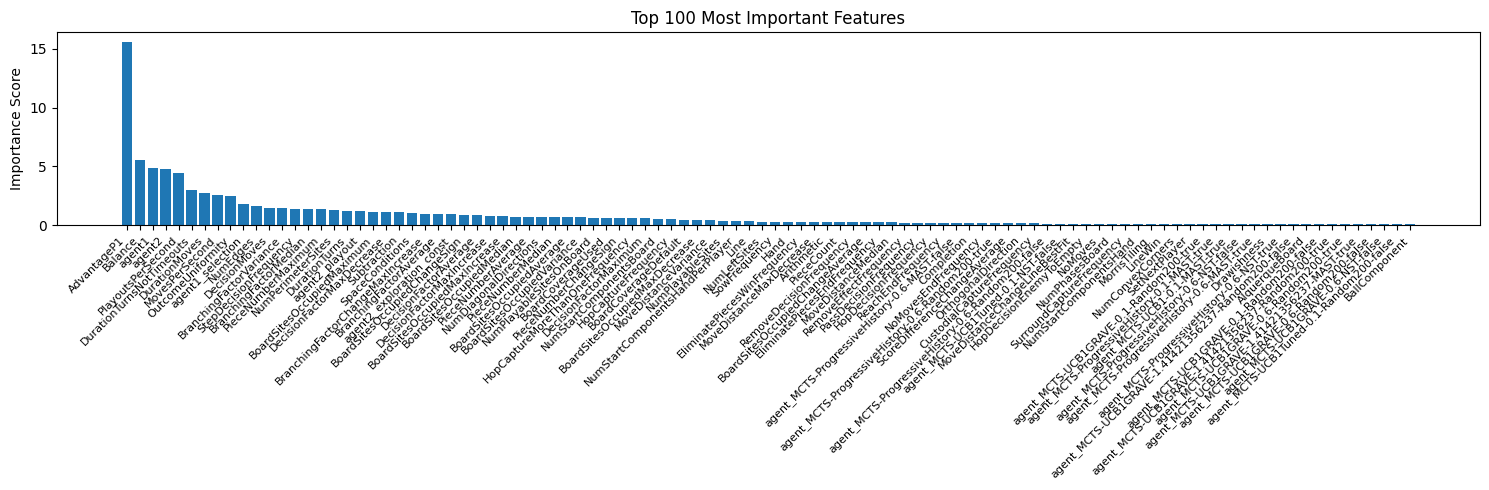

Fold 2 - RMSE: 0.43828003620913064
Fold 3


0:	learn: 0.6026672	test: 0.5978946	best: 0.5978946 (0)	total: 71ms	remaining: 3m 33s


50:	learn: 0.3986564	test: 0.4643403	best: 0.4643403 (50)	total: 4.34s	remaining: 4m 11s


100:	learn: 0.3635989	test: 0.4469736	best: 0.4469736 (100)	total: 8.87s	remaining: 4m 14s


150:	learn: 0.3433110	test: 0.4385651	best: 0.4385651 (150)	total: 13.4s	remaining: 4m 13s


200:	learn: 0.3291490	test: 0.4346708	best: 0.4346174 (199)	total: 17.9s	remaining: 4m 9s


250:	learn: 0.3177460	test: 0.4315504	best: 0.4313854 (247)	total: 22.4s	remaining: 4m 4s


300:	learn: 0.3083357	test: 0.4295825	best: 0.4295825 (300)	total: 26.8s	remaining: 4m


350:	learn: 0.3013737	test: 0.4283941	best: 0.4283941 (350)	total: 31.3s	remaining: 3m 55s


400:	learn: 0.2956291	test: 0.4271683	best: 0.4271683 (400)	total: 35.7s	remaining: 3m 51s


450:	learn: 0.2896124	test: 0.4257945	best: 0.4257945 (450)	total: 40.1s	remaining: 3m 46s


500:	learn: 0.2846829	test: 0.4251185	best: 0.4251185 (500)	total: 44.6s	remaining: 3m 42s


550:	learn: 0.2797078	test: 0.4244839	best: 0.4244458 (549)	total: 49s	remaining: 3m 38s


600:	learn: 0.2754901	test: 0.4241568	best: 0.4241192 (594)	total: 53.5s	remaining: 3m 33s


650:	learn: 0.2714975	test: 0.4237302	best: 0.4236747 (642)	total: 58s	remaining: 3m 29s


700:	learn: 0.2677654	test: 0.4231888	best: 0.4231888 (700)	total: 1m 2s	remaining: 3m 24s


750:	learn: 0.2643649	test: 0.4228798	best: 0.4228798 (750)	total: 1m 6s	remaining: 3m 20s


800:	learn: 0.2614779	test: 0.4225811	best: 0.4225681 (794)	total: 1m 11s	remaining: 3m 15s


850:	learn: 0.2582692	test: 0.4224310	best: 0.4223725 (839)	total: 1m 15s	remaining: 3m 11s


900:	learn: 0.2554047	test: 0.4222325	best: 0.4222014 (889)	total: 1m 20s	remaining: 3m 7s


950:	learn: 0.2525490	test: 0.4219146	best: 0.4219084 (942)	total: 1m 24s	remaining: 3m 2s


1000:	learn: 0.2498768	test: 0.4218964	best: 0.4218772 (996)	total: 1m 29s	remaining: 2m 58s


1050:	learn: 0.2473182	test: 0.4217233	best: 0.4216994 (1033)	total: 1m 33s	remaining: 2m 53s


1100:	learn: 0.2450608	test: 0.4217004	best: 0.4216700 (1091)	total: 1m 38s	remaining: 2m 49s


1150:	learn: 0.2424030	test: 0.4215204	best: 0.4215204 (1150)	total: 1m 42s	remaining: 2m 44s


1200:	learn: 0.2401875	test: 0.4213510	best: 0.4213451 (1199)	total: 1m 47s	remaining: 2m 40s


1250:	learn: 0.2380927	test: 0.4211952	best: 0.4211952 (1250)	total: 1m 51s	remaining: 2m 35s


1300:	learn: 0.2357791	test: 0.4212494	best: 0.4211815 (1251)	total: 1m 55s	remaining: 2m 31s


1350:	learn: 0.2339491	test: 0.4211566	best: 0.4211293 (1346)	total: 2m	remaining: 2m 27s


1400:	learn: 0.2320581	test: 0.4210921	best: 0.4210806 (1399)	total: 2m 4s	remaining: 2m 22s


1450:	learn: 0.2302205	test: 0.4209977	best: 0.4209977 (1450)	total: 2m 9s	remaining: 2m 18s


1500:	learn: 0.2284693	test: 0.4209462	best: 0.4209352 (1470)	total: 2m 13s	remaining: 2m 13s


1550:	learn: 0.2266453	test: 0.4208600	best: 0.4208600 (1550)	total: 2m 18s	remaining: 2m 9s


1600:	learn: 0.2248847	test: 0.4207062	best: 0.4207062 (1600)	total: 2m 22s	remaining: 2m 4s


1650:	learn: 0.2232366	test: 0.4206214	best: 0.4206214 (1650)	total: 2m 27s	remaining: 2m


1700:	learn: 0.2216190	test: 0.4205270	best: 0.4205270 (1700)	total: 2m 31s	remaining: 1m 55s


1750:	learn: 0.2198437	test: 0.4204339	best: 0.4204226 (1742)	total: 2m 36s	remaining: 1m 51s


1800:	learn: 0.2182467	test: 0.4204401	best: 0.4203748 (1764)	total: 2m 40s	remaining: 1m 46s


1850:	learn: 0.2166980	test: 0.4203990	best: 0.4203661 (1823)	total: 2m 45s	remaining: 1m 42s


1900:	learn: 0.2150765	test: 0.4202657	best: 0.4202657 (1900)	total: 2m 49s	remaining: 1m 37s


1950:	learn: 0.2135398	test: 0.4201224	best: 0.4201118 (1941)	total: 2m 53s	remaining: 1m 33s


2000:	learn: 0.2118963	test: 0.4200156	best: 0.4199905 (1992)	total: 2m 58s	remaining: 1m 29s


2050:	learn: 0.2104118	test: 0.4200241	best: 0.4199822 (2011)	total: 3m 2s	remaining: 1m 24s


2100:	learn: 0.2089138	test: 0.4199922	best: 0.4199822 (2011)	total: 3m 7s	remaining: 1m 20s


2150:	learn: 0.2076410	test: 0.4199503	best: 0.4199494 (2149)	total: 3m 11s	remaining: 1m 15s


2200:	learn: 0.2061473	test: 0.4199120	best: 0.4198993 (2196)	total: 3m 16s	remaining: 1m 11s


2250:	learn: 0.2047935	test: 0.4200012	best: 0.4198993 (2196)	total: 3m 20s	remaining: 1m 6s


2300:	learn: 0.2034076	test: 0.4199505	best: 0.4198993 (2196)	total: 3m 25s	remaining: 1m 2s


2350:	learn: 0.2021471	test: 0.4199366	best: 0.4198993 (2196)	total: 3m 29s	remaining: 57.9s


2400:	learn: 0.2008338	test: 0.4199126	best: 0.4198631 (2380)	total: 3m 34s	remaining: 53.4s


2450:	learn: 0.1994261	test: 0.4198455	best: 0.4198364 (2449)	total: 3m 38s	remaining: 48.9s


2500:	learn: 0.1982155	test: 0.4198347	best: 0.4198273 (2496)	total: 3m 42s	remaining: 44.5s


2550:	learn: 0.1970451	test: 0.4197736	best: 0.4197704 (2548)	total: 3m 47s	remaining: 40.1s


2600:	learn: 0.1958823	test: 0.4197079	best: 0.4196893 (2581)	total: 3m 52s	remaining: 35.6s


2650:	learn: 0.1946386	test: 0.4196493	best: 0.4196435 (2646)	total: 3m 56s	remaining: 31.2s


2700:	learn: 0.1934051	test: 0.4196275	best: 0.4196026 (2687)	total: 4m 1s	remaining: 26.7s


2750:	learn: 0.1922114	test: 0.4196721	best: 0.4196026 (2687)	total: 4m 5s	remaining: 22.2s


2800:	learn: 0.1908801	test: 0.4196318	best: 0.4196026 (2687)	total: 4m 9s	remaining: 17.8s


2850:	learn: 0.1897154	test: 0.4196430	best: 0.4196026 (2687)	total: 4m 14s	remaining: 13.3s


2900:	learn: 0.1886593	test: 0.4196283	best: 0.4196026 (2687)	total: 4m 18s	remaining: 8.83s


2950:	learn: 0.1875398	test: 0.4195746	best: 0.4195500 (2918)	total: 4m 23s	remaining: 4.37s


2999:	learn: 0.1864799	test: 0.4195802	best: 0.4195282 (2978)	total: 4m 27s	remaining: 0us

bestTest = 0.419528154
bestIteration = 2978

Shrink model to first 2979 iterations.


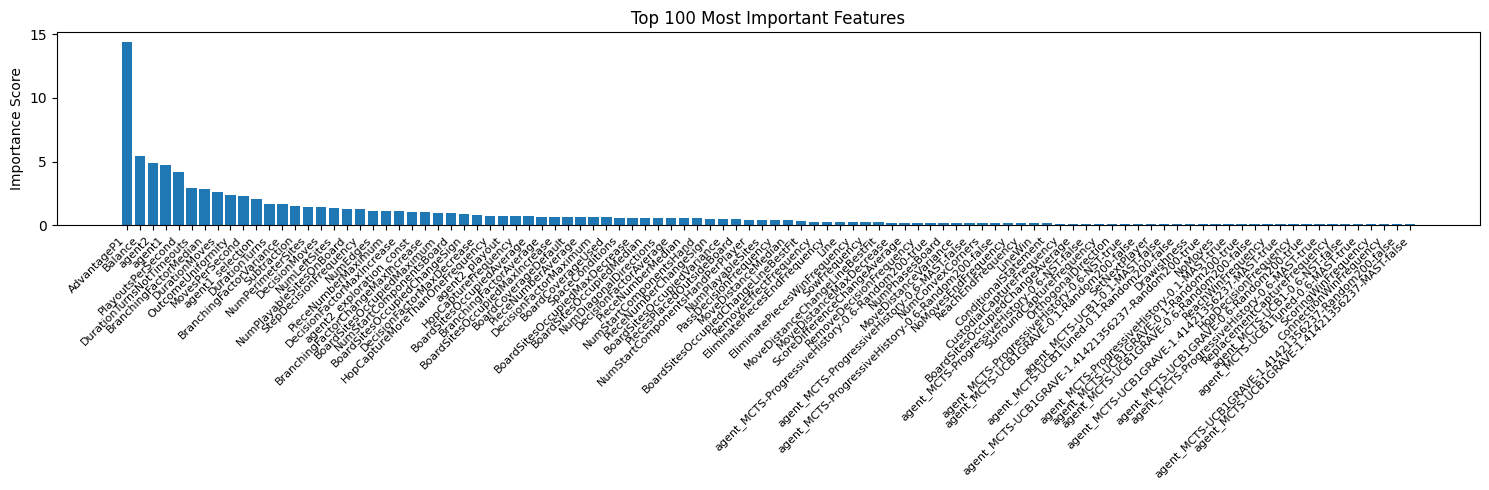

Fold 3 - RMSE: 0.41884077566858796
Fold 4


0:	learn: 0.6038668	test: 0.5910042	best: 0.5910042 (0)	total: 73.9ms	remaining: 3m 41s


50:	learn: 0.3945530	test: 0.4881498	best: 0.4881498 (50)	total: 4.07s	remaining: 3m 55s


100:	learn: 0.3558572	test: 0.4639294	best: 0.4639294 (100)	total: 8.34s	remaining: 3m 59s


150:	learn: 0.3355038	test: 0.4553055	best: 0.4553055 (150)	total: 12.6s	remaining: 3m 56s


200:	learn: 0.3229838	test: 0.4510288	best: 0.4510288 (200)	total: 16.9s	remaining: 3m 56s


250:	learn: 0.3124127	test: 0.4479922	best: 0.4479922 (250)	total: 21.3s	remaining: 3m 53s


300:	learn: 0.3039034	test: 0.4460773	best: 0.4460566 (299)	total: 25.5s	remaining: 3m 48s


350:	learn: 0.2965281	test: 0.4445743	best: 0.4445743 (350)	total: 29.7s	remaining: 3m 44s


400:	learn: 0.2906998	test: 0.4434956	best: 0.4434853 (399)	total: 34.1s	remaining: 3m 40s


450:	learn: 0.2849038	test: 0.4421293	best: 0.4421293 (450)	total: 38.4s	remaining: 3m 36s


500:	learn: 0.2801061	test: 0.4411721	best: 0.4411721 (500)	total: 42.7s	remaining: 3m 32s


550:	learn: 0.2755706	test: 0.4406552	best: 0.4406497 (549)	total: 47s	remaining: 3m 28s


600:	learn: 0.2713274	test: 0.4401602	best: 0.4401602 (600)	total: 51.4s	remaining: 3m 25s


650:	learn: 0.2675088	test: 0.4395890	best: 0.4395890 (650)	total: 55.7s	remaining: 3m 21s


700:	learn: 0.2641574	test: 0.4393572	best: 0.4393313 (684)	total: 1m	remaining: 3m 17s


750:	learn: 0.2607447	test: 0.4391648	best: 0.4391545 (749)	total: 1m 4s	remaining: 3m 13s


800:	learn: 0.2575304	test: 0.4386621	best: 0.4386621 (800)	total: 1m 9s	remaining: 3m 9s


850:	learn: 0.2547845	test: 0.4382633	best: 0.4382633 (850)	total: 1m 13s	remaining: 3m 6s


900:	learn: 0.2520176	test: 0.4380459	best: 0.4380035 (895)	total: 1m 18s	remaining: 3m 2s


950:	learn: 0.2492815	test: 0.4378767	best: 0.4378615 (947)	total: 1m 22s	remaining: 2m 58s


1000:	learn: 0.2467587	test: 0.4377200	best: 0.4377200 (1000)	total: 1m 27s	remaining: 2m 53s


1050:	learn: 0.2444980	test: 0.4375209	best: 0.4375209 (1050)	total: 1m 31s	remaining: 2m 49s


1100:	learn: 0.2421507	test: 0.4373031	best: 0.4372840 (1098)	total: 1m 35s	remaining: 2m 45s


1150:	learn: 0.2399961	test: 0.4370969	best: 0.4370924 (1149)	total: 1m 40s	remaining: 2m 41s


1200:	learn: 0.2380153	test: 0.4370584	best: 0.4369999 (1180)	total: 1m 44s	remaining: 2m 36s


1250:	learn: 0.2359728	test: 0.4368540	best: 0.4368521 (1249)	total: 1m 49s	remaining: 2m 32s


1300:	learn: 0.2340849	test: 0.4367696	best: 0.4367628 (1294)	total: 1m 53s	remaining: 2m 28s


1350:	learn: 0.2321175	test: 0.4366489	best: 0.4366489 (1350)	total: 1m 58s	remaining: 2m 24s


1400:	learn: 0.2301988	test: 0.4365008	best: 0.4364824 (1378)	total: 2m 2s	remaining: 2m 19s


1450:	learn: 0.2283779	test: 0.4363917	best: 0.4363917 (1450)	total: 2m 6s	remaining: 2m 15s


1500:	learn: 0.2262914	test: 0.4361366	best: 0.4361094 (1496)	total: 2m 11s	remaining: 2m 11s


1550:	learn: 0.2244163	test: 0.4359670	best: 0.4359670 (1550)	total: 2m 15s	remaining: 2m 6s


1600:	learn: 0.2227814	test: 0.4359098	best: 0.4358956 (1599)	total: 2m 19s	remaining: 2m 2s


1650:	learn: 0.2209933	test: 0.4358598	best: 0.4358412 (1646)	total: 2m 24s	remaining: 1m 57s


1700:	learn: 0.2193972	test: 0.4358703	best: 0.4358302 (1654)	total: 2m 28s	remaining: 1m 53s


1750:	learn: 0.2178421	test: 0.4357423	best: 0.4357407 (1749)	total: 2m 33s	remaining: 1m 49s


1800:	learn: 0.2160586	test: 0.4355582	best: 0.4355579 (1799)	total: 2m 37s	remaining: 1m 44s


1850:	learn: 0.2145721	test: 0.4355220	best: 0.4355195 (1845)	total: 2m 41s	remaining: 1m 40s


1900:	learn: 0.2130737	test: 0.4354762	best: 0.4354743 (1899)	total: 2m 46s	remaining: 1m 36s


1950:	learn: 0.2116287	test: 0.4354478	best: 0.4354360 (1948)	total: 2m 50s	remaining: 1m 31s


2000:	learn: 0.2099819	test: 0.4353734	best: 0.4353655 (1996)	total: 2m 55s	remaining: 1m 27s


2050:	learn: 0.2084592	test: 0.4352908	best: 0.4352908 (2050)	total: 2m 59s	remaining: 1m 23s


2100:	learn: 0.2071720	test: 0.4351968	best: 0.4351801 (2091)	total: 3m 4s	remaining: 1m 18s


2150:	learn: 0.2058342	test: 0.4350545	best: 0.4349956 (2145)	total: 3m 8s	remaining: 1m 14s


2200:	learn: 0.2044781	test: 0.4349420	best: 0.4349240 (2198)	total: 3m 13s	remaining: 1m 10s


2250:	learn: 0.2030895	test: 0.4348766	best: 0.4348766 (2250)	total: 3m 17s	remaining: 1m 5s


2300:	learn: 0.2017497	test: 0.4348758	best: 0.4348655 (2265)	total: 3m 21s	remaining: 1m 1s


2350:	learn: 0.2005441	test: 0.4349528	best: 0.4348655 (2265)	total: 3m 26s	remaining: 57s


2400:	learn: 0.1992606	test: 0.4350159	best: 0.4348655 (2265)	total: 3m 30s	remaining: 52.6s


2450:	learn: 0.1979702	test: 0.4350067	best: 0.4348655 (2265)	total: 3m 35s	remaining: 48.2s


2500:	learn: 0.1965831	test: 0.4350226	best: 0.4348655 (2265)	total: 3m 39s	remaining: 43.8s


2550:	learn: 0.1954001	test: 0.4349774	best: 0.4348655 (2265)	total: 3m 44s	remaining: 39.5s


2600:	learn: 0.1943181	test: 0.4350229	best: 0.4348655 (2265)	total: 3m 48s	remaining: 35.1s


2650:	learn: 0.1929944	test: 0.4348083	best: 0.4348077 (2648)	total: 3m 53s	remaining: 30.7s


2700:	learn: 0.1917844	test: 0.4347513	best: 0.4347458 (2698)	total: 3m 57s	remaining: 26.3s


2750:	learn: 0.1905154	test: 0.4347013	best: 0.4347012 (2749)	total: 4m 1s	remaining: 21.9s


2800:	learn: 0.1892683	test: 0.4346720	best: 0.4346699 (2793)	total: 4m 6s	remaining: 17.5s


2850:	learn: 0.1881387	test: 0.4347082	best: 0.4346699 (2793)	total: 4m 10s	remaining: 13.1s


2900:	learn: 0.1870022	test: 0.4347472	best: 0.4346699 (2793)	total: 4m 15s	remaining: 8.71s


2950:	learn: 0.1859180	test: 0.4347571	best: 0.4346699 (2793)	total: 4m 19s	remaining: 4.31s


2999:	learn: 0.1848079	test: 0.4347220	best: 0.4346699 (2793)	total: 4m 24s	remaining: 0us

bestTest = 0.4346699039
bestIteration = 2793

Shrink model to first 2794 iterations.


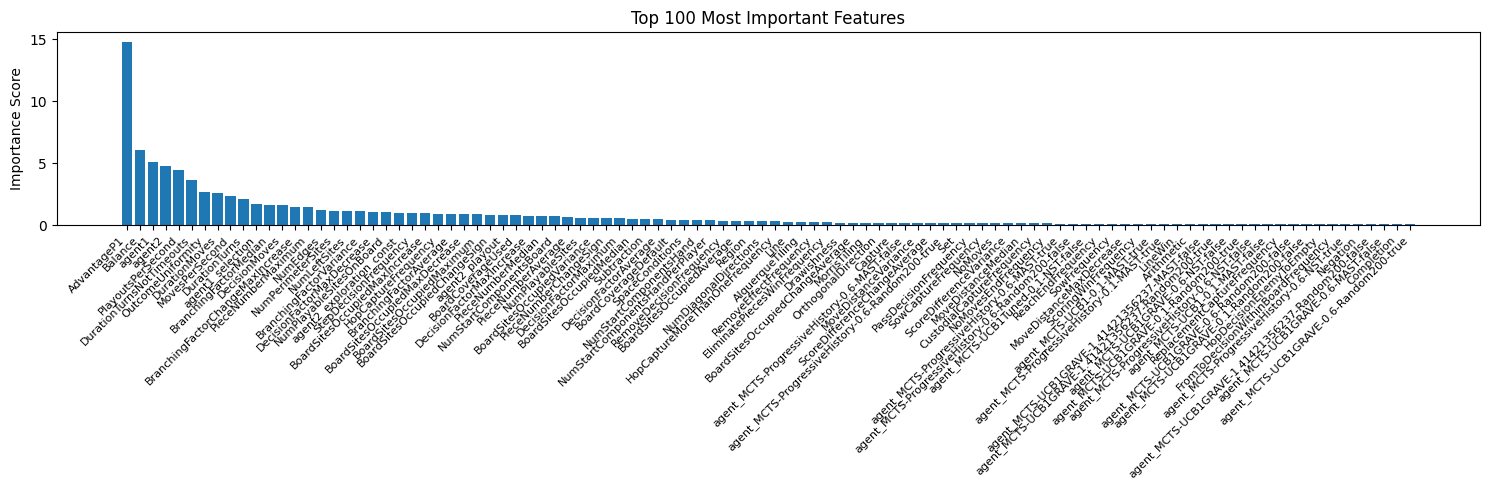

Fold 4 - RMSE: 0.4339575734912621
Fold 5


0:	learn: 0.6161555	test: 0.5418393	best: 0.5418393 (0)	total: 68.3ms	remaining: 3m 24s


50:	learn: 0.4038696	test: 0.4546082	best: 0.4546082 (50)	total: 4.25s	remaining: 4m 5s


100:	learn: 0.3674655	test: 0.4355317	best: 0.4355317 (100)	total: 8.63s	remaining: 4m 7s


150:	learn: 0.3462379	test: 0.4276327	best: 0.4276327 (150)	total: 13.1s	remaining: 4m 6s


200:	learn: 0.3306829	test: 0.4222466	best: 0.4222466 (200)	total: 17.4s	remaining: 4m 2s


250:	learn: 0.3196398	test: 0.4189572	best: 0.4189017 (248)	total: 21.9s	remaining: 3m 59s


300:	learn: 0.3108077	test: 0.4165406	best: 0.4165406 (300)	total: 26.3s	remaining: 3m 56s


350:	learn: 0.3032391	test: 0.4154002	best: 0.4154002 (350)	total: 30.8s	remaining: 3m 52s


400:	learn: 0.2965899	test: 0.4142048	best: 0.4142048 (400)	total: 35.2s	remaining: 3m 48s


450:	learn: 0.2908402	test: 0.4133516	best: 0.4133516 (450)	total: 39.7s	remaining: 3m 44s


500:	learn: 0.2855738	test: 0.4126614	best: 0.4126516 (497)	total: 44.1s	remaining: 3m 39s


550:	learn: 0.2805146	test: 0.4121764	best: 0.4121764 (550)	total: 48.5s	remaining: 3m 35s


600:	learn: 0.2763786	test: 0.4116184	best: 0.4116150 (599)	total: 53s	remaining: 3m 31s


650:	learn: 0.2723872	test: 0.4109613	best: 0.4109557 (646)	total: 57.4s	remaining: 3m 27s


700:	learn: 0.2687029	test: 0.4104730	best: 0.4104730 (700)	total: 1m 1s	remaining: 3m 22s


750:	learn: 0.2653641	test: 0.4098963	best: 0.4098963 (750)	total: 1m 6s	remaining: 3m 18s


800:	learn: 0.2621179	test: 0.4097311	best: 0.4097149 (799)	total: 1m 10s	remaining: 3m 14s


850:	learn: 0.2589818	test: 0.4094102	best: 0.4094102 (850)	total: 1m 15s	remaining: 3m 10s


900:	learn: 0.2559773	test: 0.4092150	best: 0.4092084 (898)	total: 1m 19s	remaining: 3m 5s


950:	learn: 0.2527778	test: 0.4088397	best: 0.4088120 (945)	total: 1m 24s	remaining: 3m 1s


1000:	learn: 0.2501992	test: 0.4086222	best: 0.4086126 (985)	total: 1m 28s	remaining: 2m 56s


1050:	learn: 0.2477414	test: 0.4082442	best: 0.4082442 (1050)	total: 1m 33s	remaining: 2m 52s


1100:	learn: 0.2451955	test: 0.4082072	best: 0.4081881 (1096)	total: 1m 37s	remaining: 2m 48s


1150:	learn: 0.2428154	test: 0.4080498	best: 0.4080498 (1150)	total: 1m 42s	remaining: 2m 44s


1200:	learn: 0.2406011	test: 0.4079211	best: 0.4078970 (1192)	total: 1m 46s	remaining: 2m 39s


1250:	learn: 0.2383770	test: 0.4078298	best: 0.4078265 (1249)	total: 1m 51s	remaining: 2m 35s


1300:	learn: 0.2361187	test: 0.4076230	best: 0.4076163 (1291)	total: 1m 55s	remaining: 2m 31s


1350:	learn: 0.2339482	test: 0.4073312	best: 0.4073311 (1348)	total: 2m	remaining: 2m 26s


1400:	learn: 0.2319356	test: 0.4073193	best: 0.4073046 (1395)	total: 2m 4s	remaining: 2m 22s


1450:	learn: 0.2300167	test: 0.4072460	best: 0.4072458 (1440)	total: 2m 9s	remaining: 2m 17s


1500:	learn: 0.2281248	test: 0.4071189	best: 0.4071189 (1500)	total: 2m 13s	remaining: 2m 13s


1550:	learn: 0.2262950	test: 0.4069771	best: 0.4069771 (1550)	total: 2m 18s	remaining: 2m 9s


1600:	learn: 0.2245780	test: 0.4069070	best: 0.4068932 (1596)	total: 2m 22s	remaining: 2m 4s


1650:	learn: 0.2228738	test: 0.4068698	best: 0.4068495 (1644)	total: 2m 27s	remaining: 2m


1700:	learn: 0.2211178	test: 0.4068408	best: 0.4068302 (1674)	total: 2m 31s	remaining: 1m 55s


1750:	learn: 0.2194041	test: 0.4067009	best: 0.4066910 (1722)	total: 2m 36s	remaining: 1m 51s


1800:	learn: 0.2178034	test: 0.4066472	best: 0.4066321 (1798)	total: 2m 40s	remaining: 1m 46s


1850:	learn: 0.2161912	test: 0.4065887	best: 0.4065732 (1837)	total: 2m 45s	remaining: 1m 42s


1900:	learn: 0.2145536	test: 0.4065215	best: 0.4065057 (1897)	total: 2m 49s	remaining: 1m 38s


1950:	learn: 0.2129917	test: 0.4063636	best: 0.4063543 (1947)	total: 2m 54s	remaining: 1m 33s


2000:	learn: 0.2114167	test: 0.4062433	best: 0.4062236 (1998)	total: 2m 58s	remaining: 1m 29s


2050:	learn: 0.2099431	test: 0.4062890	best: 0.4062236 (1998)	total: 3m 2s	remaining: 1m 24s


2100:	learn: 0.2084436	test: 0.4062395	best: 0.4062166 (2072)	total: 3m 7s	remaining: 1m 20s


2150:	learn: 0.2070344	test: 0.4062010	best: 0.4061797 (2140)	total: 3m 11s	remaining: 1m 15s


2200:	learn: 0.2055764	test: 0.4061767	best: 0.4061767 (2200)	total: 3m 16s	remaining: 1m 11s


2250:	learn: 0.2041661	test: 0.4061320	best: 0.4060916 (2246)	total: 3m 20s	remaining: 1m 6s


2300:	learn: 0.2028390	test: 0.4061032	best: 0.4060847 (2277)	total: 3m 25s	remaining: 1m 2s


2350:	learn: 0.2015505	test: 0.4060438	best: 0.4060397 (2348)	total: 3m 29s	remaining: 57.9s


2400:	learn: 0.2002249	test: 0.4060842	best: 0.4060354 (2357)	total: 3m 34s	remaining: 53.5s


2450:	learn: 0.1988843	test: 0.4060472	best: 0.4060354 (2357)	total: 3m 38s	remaining: 49s


2500:	learn: 0.1976392	test: 0.4060218	best: 0.4060140 (2494)	total: 3m 43s	remaining: 44.5s


2550:	learn: 0.1963723	test: 0.4059885	best: 0.4059870 (2549)	total: 3m 47s	remaining: 40.1s


2600:	learn: 0.1951826	test: 0.4059137	best: 0.4059137 (2600)	total: 3m 52s	remaining: 35.6s


2650:	learn: 0.1939000	test: 0.4058166	best: 0.4058166 (2650)	total: 3m 56s	remaining: 31.2s


2700:	learn: 0.1927274	test: 0.4057888	best: 0.4057854 (2663)	total: 4m 1s	remaining: 26.7s


2750:	learn: 0.1915254	test: 0.4057423	best: 0.4057354 (2747)	total: 4m 5s	remaining: 22.2s


2800:	learn: 0.1903121	test: 0.4056399	best: 0.4056310 (2796)	total: 4m 10s	remaining: 17.8s


2850:	learn: 0.1891045	test: 0.4056594	best: 0.4056310 (2796)	total: 4m 14s	remaining: 13.3s


2900:	learn: 0.1880368	test: 0.4056033	best: 0.4055943 (2898)	total: 4m 19s	remaining: 8.85s


2950:	learn: 0.1868574	test: 0.4055787	best: 0.4055443 (2935)	total: 4m 23s	remaining: 4.38s


2999:	learn: 0.1857390	test: 0.4055766	best: 0.4055443 (2935)	total: 4m 28s	remaining: 0us

bestTest = 0.4055443117
bestIteration = 2935

Shrink model to first 2936 iterations.


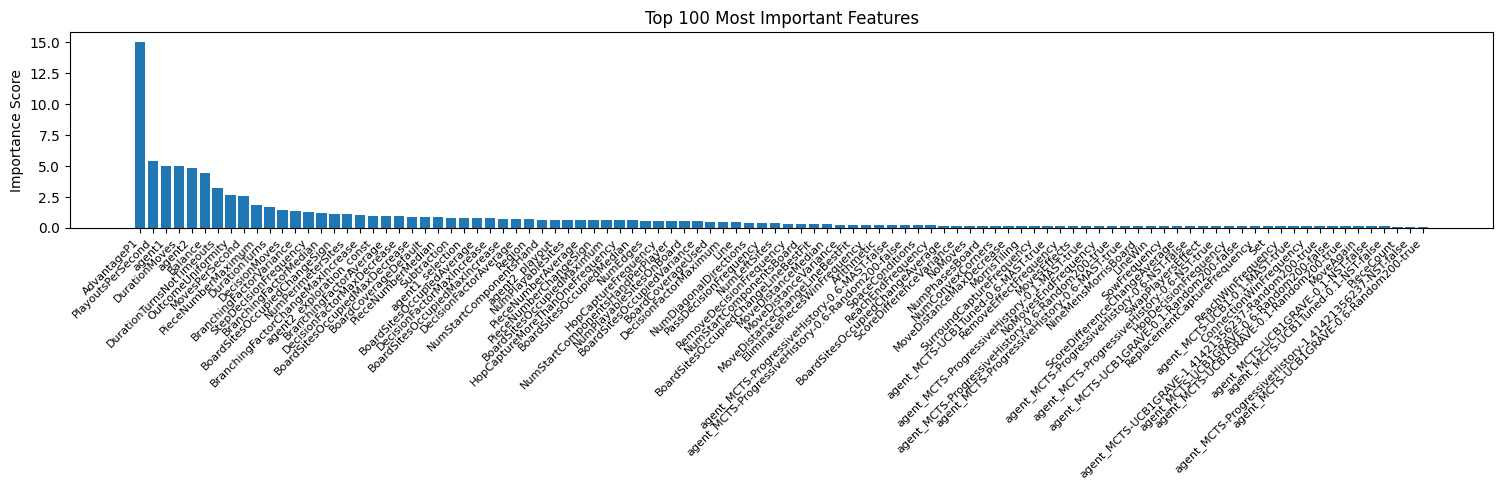

Fold 5 - RMSE: 0.40505902724897835
List of oof scores: [0.42477071094795166, 0.43828003620913064, 0.41884077566858796, 0.4339575734912621, 0.40505902724897835]
Average oof score: 0.42418162471318216


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6178523	test: 0.5306510	best: 0.5306510 (0)	total: 69.2ms	remaining: 3m 27s


50:	learn: 0.4016158	test: 0.4488294	best: 0.4488294 (50)	total: 4.23s	remaining: 4m 4s


100:	learn: 0.3617082	test: 0.4309802	best: 0.4309802 (100)	total: 8.53s	remaining: 4m 4s


150:	learn: 0.3403808	test: 0.4248865	best: 0.4248865 (150)	total: 12.8s	remaining: 4m 1s


200:	learn: 0.3262706	test: 0.4204546	best: 0.4203707 (199)	total: 17.1s	remaining: 3m 58s


250:	learn: 0.3154102	test: 0.4181086	best: 0.4180990 (249)	total: 21.3s	remaining: 3m 53s


300:	learn: 0.3068107	test: 0.4164829	best: 0.4164278 (298)	total: 25.7s	remaining: 3m 50s


350:	learn: 0.2997217	test: 0.4159243	best: 0.4159163 (345)	total: 30s	remaining: 3m 46s


400:	learn: 0.2928258	test: 0.4149571	best: 0.4149571 (400)	total: 34.2s	remaining: 3m 41s


450:	learn: 0.2871530	test: 0.4138117	best: 0.4138117 (450)	total: 38.6s	remaining: 3m 38s


500:	learn: 0.2818584	test: 0.4132398	best: 0.4132336 (499)	total: 42.8s	remaining: 3m 33s


550:	learn: 0.2771176	test: 0.4129281	best: 0.4129007 (544)	total: 47.1s	remaining: 3m 29s


600:	learn: 0.2729503	test: 0.4121806	best: 0.4121806 (600)	total: 51.4s	remaining: 3m 25s


650:	learn: 0.2688491	test: 0.4116121	best: 0.4116121 (650)	total: 55.8s	remaining: 3m 21s


700:	learn: 0.2653178	test: 0.4109279	best: 0.4109279 (700)	total: 1m	remaining: 3m 17s


750:	learn: 0.2620465	test: 0.4105230	best: 0.4105106 (749)	total: 1m 4s	remaining: 3m 13s


800:	learn: 0.2587245	test: 0.4101065	best: 0.4100870 (799)	total: 1m 8s	remaining: 3m 9s


850:	learn: 0.2557823	test: 0.4099208	best: 0.4099006 (846)	total: 1m 13s	remaining: 3m 5s


900:	learn: 0.2527461	test: 0.4096327	best: 0.4096327 (900)	total: 1m 17s	remaining: 3m


950:	learn: 0.2500500	test: 0.4093440	best: 0.4093140 (942)	total: 1m 22s	remaining: 2m 56s


1000:	learn: 0.2475735	test: 0.4091598	best: 0.4091598 (1000)	total: 1m 26s	remaining: 2m 52s


1050:	learn: 0.2450945	test: 0.4088459	best: 0.4088397 (1049)	total: 1m 30s	remaining: 2m 48s


1100:	learn: 0.2427403	test: 0.4084576	best: 0.4084576 (1100)	total: 1m 35s	remaining: 2m 44s


1150:	learn: 0.2405216	test: 0.4082651	best: 0.4082651 (1150)	total: 1m 39s	remaining: 2m 39s


1200:	learn: 0.2384446	test: 0.4079768	best: 0.4079768 (1200)	total: 1m 43s	remaining: 2m 35s


1250:	learn: 0.2364762	test: 0.4077407	best: 0.4077407 (1250)	total: 1m 48s	remaining: 2m 31s


1300:	learn: 0.2343341	test: 0.4075202	best: 0.4075126 (1297)	total: 1m 52s	remaining: 2m 27s


1350:	learn: 0.2323875	test: 0.4073715	best: 0.4073715 (1350)	total: 1m 57s	remaining: 2m 22s


1400:	learn: 0.2304137	test: 0.4071498	best: 0.4071498 (1400)	total: 2m 1s	remaining: 2m 18s


1450:	learn: 0.2283980	test: 0.4070022	best: 0.4069882 (1433)	total: 2m 5s	remaining: 2m 14s


1500:	learn: 0.2263855	test: 0.4068317	best: 0.4068275 (1496)	total: 2m 10s	remaining: 2m 10s


1550:	learn: 0.2246787	test: 0.4066718	best: 0.4066702 (1547)	total: 2m 14s	remaining: 2m 5s


1600:	learn: 0.2229366	test: 0.4066900	best: 0.4066464 (1552)	total: 2m 19s	remaining: 2m 1s


1650:	learn: 0.2211291	test: 0.4066034	best: 0.4065969 (1648)	total: 2m 23s	remaining: 1m 57s


1700:	learn: 0.2193075	test: 0.4063835	best: 0.4063835 (1700)	total: 2m 27s	remaining: 1m 52s


1750:	learn: 0.2175702	test: 0.4063539	best: 0.4063459 (1747)	total: 2m 32s	remaining: 1m 48s


1800:	learn: 0.2159950	test: 0.4063430	best: 0.4063214 (1773)	total: 2m 36s	remaining: 1m 44s


1850:	learn: 0.2143551	test: 0.4062904	best: 0.4062676 (1832)	total: 2m 40s	remaining: 1m 39s


1900:	learn: 0.2128601	test: 0.4063120	best: 0.4062615 (1872)	total: 2m 45s	remaining: 1m 35s


1950:	learn: 0.2113553	test: 0.4062444	best: 0.4062444 (1950)	total: 2m 49s	remaining: 1m 31s


2000:	learn: 0.2099480	test: 0.4061128	best: 0.4061108 (1999)	total: 2m 54s	remaining: 1m 26s


2050:	learn: 0.2084566	test: 0.4061542	best: 0.4060947 (2011)	total: 2m 58s	remaining: 1m 22s


2100:	learn: 0.2069250	test: 0.4061114	best: 0.4060781 (2083)	total: 3m 2s	remaining: 1m 18s


2150:	learn: 0.2053815	test: 0.4060893	best: 0.4060781 (2083)	total: 3m 7s	remaining: 1m 13s


2200:	learn: 0.2041497	test: 0.4061201	best: 0.4060719 (2158)	total: 3m 11s	remaining: 1m 9s


2250:	learn: 0.2027116	test: 0.4060475	best: 0.4060362 (2244)	total: 3m 16s	remaining: 1m 5s


2300:	learn: 0.2013871	test: 0.4060041	best: 0.4060041 (2300)	total: 3m 20s	remaining: 1m


2350:	learn: 0.2001838	test: 0.4059649	best: 0.4059479 (2329)	total: 3m 25s	remaining: 56.6s


2400:	learn: 0.1989469	test: 0.4059528	best: 0.4059369 (2363)	total: 3m 29s	remaining: 52.2s


2450:	learn: 0.1977478	test: 0.4058854	best: 0.4058810 (2445)	total: 3m 33s	remaining: 47.9s


2500:	learn: 0.1964514	test: 0.4058732	best: 0.4058699 (2482)	total: 3m 38s	remaining: 43.5s


2550:	learn: 0.1952867	test: 0.4058382	best: 0.4058323 (2540)	total: 3m 42s	remaining: 39.2s


2600:	learn: 0.1940278	test: 0.4057490	best: 0.4057490 (2600)	total: 3m 47s	remaining: 34.8s


2650:	learn: 0.1927295	test: 0.4056883	best: 0.4056883 (2650)	total: 3m 51s	remaining: 30.5s


2700:	learn: 0.1915748	test: 0.4057046	best: 0.4056777 (2657)	total: 3m 55s	remaining: 26.1s


2750:	learn: 0.1904262	test: 0.4055862	best: 0.4055841 (2748)	total: 4m	remaining: 21.7s


2800:	learn: 0.1893074	test: 0.4055736	best: 0.4055623 (2794)	total: 4m 4s	remaining: 17.4s


2850:	learn: 0.1880657	test: 0.4055666	best: 0.4055572 (2848)	total: 4m 8s	remaining: 13s


2900:	learn: 0.1868586	test: 0.4055777	best: 0.4055572 (2848)	total: 4m 13s	remaining: 8.64s


2950:	learn: 0.1856696	test: 0.4055550	best: 0.4055416 (2940)	total: 4m 17s	remaining: 4.28s


2999:	learn: 0.1845880	test: 0.4055449	best: 0.4055382 (2961)	total: 4m 21s	remaining: 0us

bestTest = 0.4055382352
bestIteration = 2961

Shrink model to first 2962 iterations.


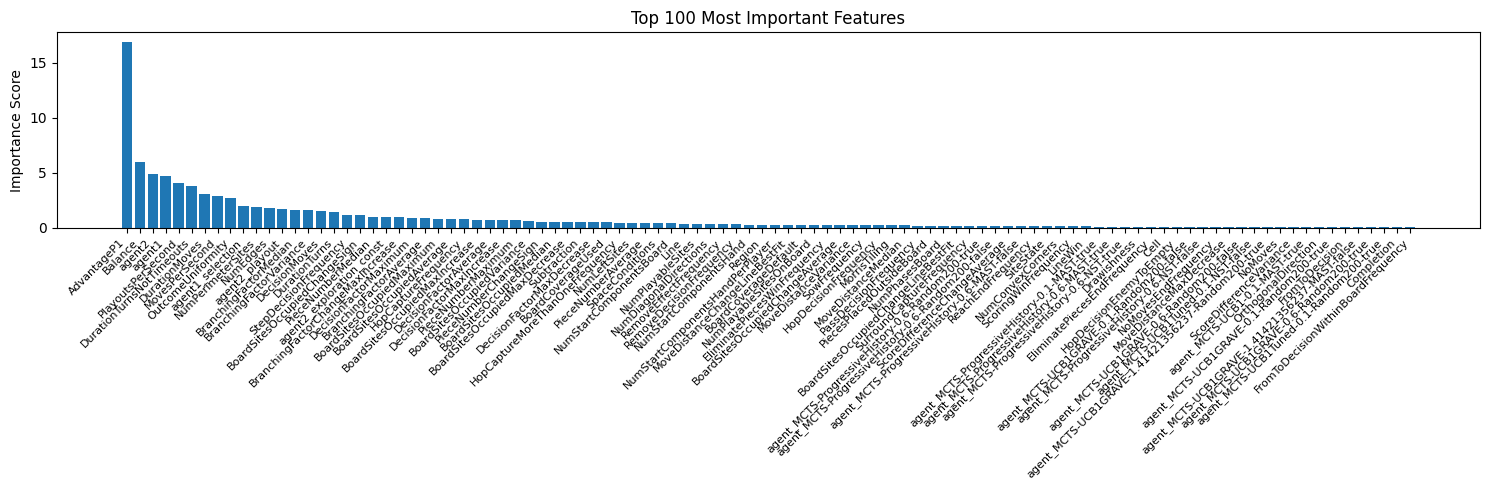

Fold 1 - RMSE: 0.40519543005117914
Fold 2


0:	learn: 0.6142155	test: 0.5369767	best: 0.5369767 (0)	total: 76.2ms	remaining: 3m 48s


50:	learn: 0.3988451	test: 0.4287248	best: 0.4287248 (50)	total: 4.28s	remaining: 4m 7s


100:	learn: 0.3590976	test: 0.4144202	best: 0.4144202 (100)	total: 8.74s	remaining: 4m 10s


150:	learn: 0.3378271	test: 0.4076415	best: 0.4076415 (150)	total: 13.2s	remaining: 4m 8s


200:	learn: 0.3233865	test: 0.4052725	best: 0.4052725 (200)	total: 17.6s	remaining: 4m 5s


250:	learn: 0.3131452	test: 0.4041188	best: 0.4041188 (250)	total: 22.1s	remaining: 4m 1s


300:	learn: 0.3048742	test: 0.4028918	best: 0.4028888 (299)	total: 26.6s	remaining: 3m 58s


350:	learn: 0.2972699	test: 0.4020427	best: 0.4020427 (350)	total: 31.1s	remaining: 3m 54s


400:	learn: 0.2907722	test: 0.4010748	best: 0.4010748 (400)	total: 35.6s	remaining: 3m 50s


450:	learn: 0.2846312	test: 0.4004269	best: 0.4004269 (450)	total: 40s	remaining: 3m 45s


500:	learn: 0.2797631	test: 0.4001335	best: 0.4001335 (500)	total: 44.5s	remaining: 3m 41s


550:	learn: 0.2753973	test: 0.3997195	best: 0.3997040 (549)	total: 49.1s	remaining: 3m 38s


600:	learn: 0.2714763	test: 0.3995928	best: 0.3995653 (564)	total: 53.7s	remaining: 3m 34s


650:	learn: 0.2678316	test: 0.3994233	best: 0.3994037 (649)	total: 58.3s	remaining: 3m 30s


700:	learn: 0.2644136	test: 0.3993306	best: 0.3993034 (698)	total: 1m 2s	remaining: 3m 26s


750:	learn: 0.2609892	test: 0.3992515	best: 0.3991898 (728)	total: 1m 7s	remaining: 3m 21s


800:	learn: 0.2577353	test: 0.3992139	best: 0.3991640 (768)	total: 1m 11s	remaining: 3m 17s


850:	learn: 0.2547705	test: 0.3991943	best: 0.3991544 (843)	total: 1m 16s	remaining: 3m 12s


900:	learn: 0.2520362	test: 0.3990504	best: 0.3989860 (892)	total: 1m 20s	remaining: 3m 8s


950:	learn: 0.2495192	test: 0.3989515	best: 0.3989328 (940)	total: 1m 25s	remaining: 3m 4s


1000:	learn: 0.2469755	test: 0.3987460	best: 0.3987460 (1000)	total: 1m 30s	remaining: 2m 59s


1050:	learn: 0.2443569	test: 0.3988187	best: 0.3987290 (1005)	total: 1m 34s	remaining: 2m 55s


1100:	learn: 0.2419314	test: 0.3987685	best: 0.3987290 (1005)	total: 1m 39s	remaining: 2m 51s


1150:	learn: 0.2395229	test: 0.3987143	best: 0.3987143 (1150)	total: 1m 43s	remaining: 2m 46s


1200:	learn: 0.2371742	test: 0.3986807	best: 0.3986258 (1177)	total: 1m 48s	remaining: 2m 42s


1250:	learn: 0.2351009	test: 0.3986649	best: 0.3986258 (1177)	total: 1m 52s	remaining: 2m 37s


1300:	learn: 0.2331805	test: 0.3985854	best: 0.3985823 (1296)	total: 1m 57s	remaining: 2m 33s


1350:	learn: 0.2311985	test: 0.3985752	best: 0.3985691 (1325)	total: 2m 2s	remaining: 2m 29s


1400:	learn: 0.2291893	test: 0.3985851	best: 0.3985669 (1351)	total: 2m 6s	remaining: 2m 24s


1450:	learn: 0.2270771	test: 0.3984809	best: 0.3984790 (1448)	total: 2m 11s	remaining: 2m 20s


1500:	learn: 0.2252224	test: 0.3984253	best: 0.3983567 (1471)	total: 2m 15s	remaining: 2m 15s


1550:	learn: 0.2233562	test: 0.3983729	best: 0.3983567 (1471)	total: 2m 20s	remaining: 2m 11s


1600:	learn: 0.2216555	test: 0.3984958	best: 0.3983567 (1471)	total: 2m 25s	remaining: 2m 6s


1650:	learn: 0.2200361	test: 0.3984763	best: 0.3983567 (1471)	total: 2m 29s	remaining: 2m 2s


1700:	learn: 0.2182910	test: 0.3984793	best: 0.3983567 (1471)	total: 2m 34s	remaining: 1m 57s


1750:	learn: 0.2166803	test: 0.3985662	best: 0.3983567 (1471)	total: 2m 39s	remaining: 1m 53s


1800:	learn: 0.2152724	test: 0.3985543	best: 0.3983567 (1471)	total: 2m 43s	remaining: 1m 48s


1850:	learn: 0.2138204	test: 0.3985283	best: 0.3983567 (1471)	total: 2m 48s	remaining: 1m 44s


1900:	learn: 0.2122273	test: 0.3985934	best: 0.3983567 (1471)	total: 2m 52s	remaining: 1m 39s


1950:	learn: 0.2108325	test: 0.3985443	best: 0.3983567 (1471)	total: 2m 57s	remaining: 1m 35s


2000:	learn: 0.2092515	test: 0.3985728	best: 0.3983567 (1471)	total: 3m 2s	remaining: 1m 30s


2050:	learn: 0.2078855	test: 0.3986418	best: 0.3983567 (1471)	total: 3m 6s	remaining: 1m 26s


2100:	learn: 0.2064478	test: 0.3985781	best: 0.3983567 (1471)	total: 3m 11s	remaining: 1m 21s


2150:	learn: 0.2050944	test: 0.3986435	best: 0.3983567 (1471)	total: 3m 15s	remaining: 1m 17s


2200:	learn: 0.2037659	test: 0.3986754	best: 0.3983567 (1471)	total: 3m 20s	remaining: 1m 12s


2250:	learn: 0.2023403	test: 0.3986393	best: 0.3983567 (1471)	total: 3m 25s	remaining: 1m 8s


2300:	learn: 0.2009238	test: 0.3986300	best: 0.3983567 (1471)	total: 3m 29s	remaining: 1m 3s


2350:	learn: 0.1995751	test: 0.3986221	best: 0.3983567 (1471)	total: 3m 34s	remaining: 59.2s


2400:	learn: 0.1983396	test: 0.3985638	best: 0.3983567 (1471)	total: 3m 39s	remaining: 54.6s


2450:	learn: 0.1970464	test: 0.3985557	best: 0.3983567 (1471)	total: 3m 43s	remaining: 50.1s


2500:	learn: 0.1957978	test: 0.3985416	best: 0.3983567 (1471)	total: 3m 48s	remaining: 45.5s


2550:	learn: 0.1946216	test: 0.3985671	best: 0.3983567 (1471)	total: 3m 52s	remaining: 41s


2600:	learn: 0.1934195	test: 0.3985991	best: 0.3983567 (1471)	total: 3m 57s	remaining: 36.4s


2650:	learn: 0.1921829	test: 0.3986273	best: 0.3983567 (1471)	total: 4m 2s	remaining: 31.9s


2700:	learn: 0.1910985	test: 0.3985911	best: 0.3983567 (1471)	total: 4m 6s	remaining: 27.3s


2750:	learn: 0.1899805	test: 0.3986427	best: 0.3983567 (1471)	total: 4m 11s	remaining: 22.8s


2800:	learn: 0.1887718	test: 0.3987112	best: 0.3983567 (1471)	total: 4m 16s	remaining: 18.2s


2850:	learn: 0.1876971	test: 0.3987166	best: 0.3983567 (1471)	total: 4m 20s	remaining: 13.6s


2900:	learn: 0.1864588	test: 0.3987421	best: 0.3983567 (1471)	total: 4m 25s	remaining: 9.06s


2950:	learn: 0.1852195	test: 0.3987416	best: 0.3983567 (1471)	total: 4m 30s	remaining: 4.49s


2999:	learn: 0.1841077	test: 0.3987388	best: 0.3983567 (1471)	total: 4m 34s	remaining: 0us

bestTest = 0.3983566559
bestIteration = 1471

Shrink model to first 1472 iterations.


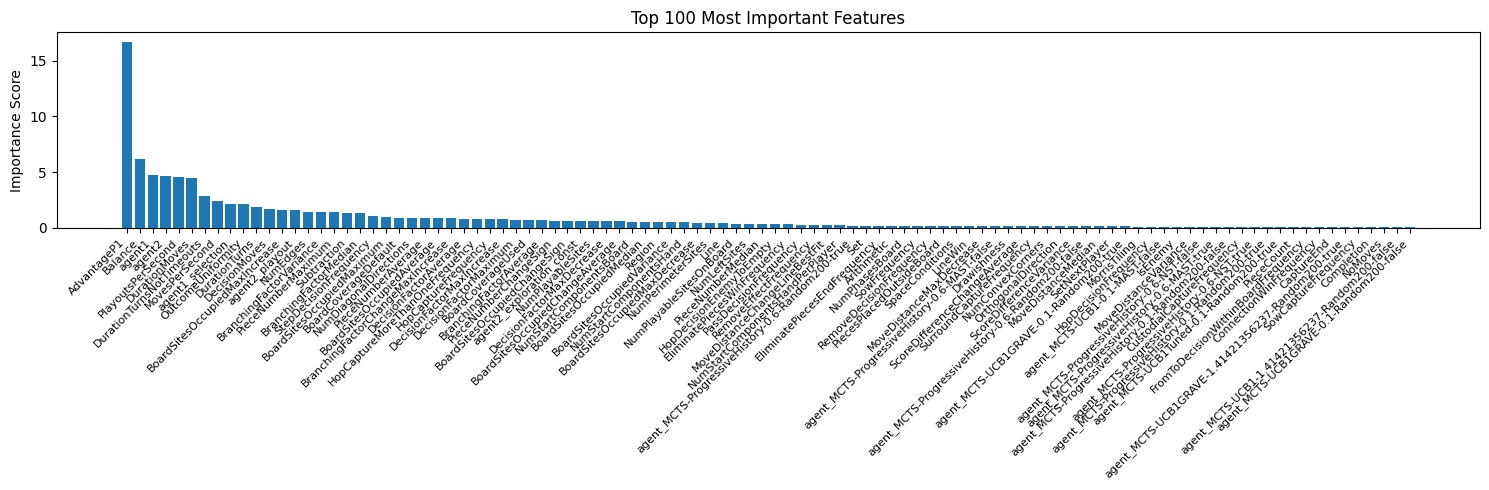

Fold 2 - RMSE: 0.39805751261528893
Fold 3


0:	learn: 0.6021486	test: 0.6067315	best: 0.6067315 (0)	total: 72.5ms	remaining: 3m 37s


50:	learn: 0.3932558	test: 0.4877546	best: 0.4877546 (50)	total: 4.17s	remaining: 4m


100:	learn: 0.3538067	test: 0.4605749	best: 0.4605749 (100)	total: 8.5s	remaining: 4m 4s


150:	learn: 0.3342592	test: 0.4500974	best: 0.4500668 (149)	total: 12.9s	remaining: 4m 2s


200:	learn: 0.3214569	test: 0.4443864	best: 0.4443864 (200)	total: 17.2s	remaining: 3m 59s


250:	learn: 0.3112883	test: 0.4406054	best: 0.4406054 (250)	total: 21.6s	remaining: 3m 56s


300:	learn: 0.3037587	test: 0.4384934	best: 0.4384934 (300)	total: 26s	remaining: 3m 53s


350:	learn: 0.2963870	test: 0.4361635	best: 0.4361635 (350)	total: 30.4s	remaining: 3m 49s


400:	learn: 0.2900129	test: 0.4347630	best: 0.4347564 (399)	total: 34.8s	remaining: 3m 45s


450:	learn: 0.2850103	test: 0.4337183	best: 0.4337183 (450)	total: 39.2s	remaining: 3m 41s


500:	learn: 0.2801173	test: 0.4331159	best: 0.4330811 (499)	total: 43.6s	remaining: 3m 37s


550:	learn: 0.2757506	test: 0.4322809	best: 0.4322809 (550)	total: 48s	remaining: 3m 33s


600:	learn: 0.2716484	test: 0.4315383	best: 0.4315308 (599)	total: 52.4s	remaining: 3m 28s


650:	learn: 0.2678095	test: 0.4310946	best: 0.4310946 (650)	total: 56.8s	remaining: 3m 24s


700:	learn: 0.2643164	test: 0.4304117	best: 0.4304083 (697)	total: 1m 1s	remaining: 3m 20s


750:	learn: 0.2612813	test: 0.4303296	best: 0.4303296 (750)	total: 1m 5s	remaining: 3m 16s


800:	learn: 0.2579941	test: 0.4299673	best: 0.4299178 (798)	total: 1m 10s	remaining: 3m 12s


850:	learn: 0.2551587	test: 0.4296542	best: 0.4296542 (850)	total: 1m 14s	remaining: 3m 8s


900:	learn: 0.2522391	test: 0.4293233	best: 0.4293233 (900)	total: 1m 18s	remaining: 3m 3s


950:	learn: 0.2496795	test: 0.4289525	best: 0.4289234 (941)	total: 1m 23s	remaining: 2m 59s


1000:	learn: 0.2471208	test: 0.4285556	best: 0.4285556 (1000)	total: 1m 27s	remaining: 2m 55s


1050:	learn: 0.2446399	test: 0.4284288	best: 0.4284160 (1046)	total: 1m 32s	remaining: 2m 51s


1100:	learn: 0.2424134	test: 0.4280790	best: 0.4280790 (1100)	total: 1m 36s	remaining: 2m 46s


1150:	learn: 0.2402982	test: 0.4279483	best: 0.4278849 (1140)	total: 1m 41s	remaining: 2m 42s


1200:	learn: 0.2380355	test: 0.4277328	best: 0.4276971 (1198)	total: 1m 45s	remaining: 2m 38s


1250:	learn: 0.2359294	test: 0.4274763	best: 0.4274746 (1249)	total: 1m 50s	remaining: 2m 33s


1300:	learn: 0.2339020	test: 0.4273412	best: 0.4273341 (1299)	total: 1m 54s	remaining: 2m 29s


1350:	learn: 0.2318118	test: 0.4271452	best: 0.4271452 (1350)	total: 1m 58s	remaining: 2m 25s


1400:	learn: 0.2297955	test: 0.4268483	best: 0.4268483 (1400)	total: 2m 3s	remaining: 2m 20s


1450:	learn: 0.2280282	test: 0.4267574	best: 0.4267554 (1446)	total: 2m 7s	remaining: 2m 16s


1500:	learn: 0.2262758	test: 0.4265472	best: 0.4265385 (1499)	total: 2m 12s	remaining: 2m 12s


1550:	learn: 0.2245073	test: 0.4262379	best: 0.4262379 (1550)	total: 2m 16s	remaining: 2m 7s


1600:	learn: 0.2227815	test: 0.4260740	best: 0.4260736 (1597)	total: 2m 21s	remaining: 2m 3s


1650:	learn: 0.2210028	test: 0.4259233	best: 0.4259228 (1646)	total: 2m 25s	remaining: 1m 59s


1700:	learn: 0.2193395	test: 0.4257872	best: 0.4257872 (1700)	total: 2m 30s	remaining: 1m 54s


1750:	learn: 0.2177708	test: 0.4256355	best: 0.4256328 (1744)	total: 2m 34s	remaining: 1m 50s


1800:	learn: 0.2162100	test: 0.4256005	best: 0.4255586 (1778)	total: 2m 39s	remaining: 1m 45s


1850:	learn: 0.2146024	test: 0.4255193	best: 0.4255034 (1846)	total: 2m 43s	remaining: 1m 41s


1900:	learn: 0.2131057	test: 0.4255080	best: 0.4254810 (1866)	total: 2m 47s	remaining: 1m 37s


1950:	learn: 0.2115093	test: 0.4253617	best: 0.4253578 (1947)	total: 2m 52s	remaining: 1m 32s


2000:	learn: 0.2099184	test: 0.4252465	best: 0.4252241 (1999)	total: 2m 56s	remaining: 1m 28s


2050:	learn: 0.2084593	test: 0.4251410	best: 0.4251342 (2048)	total: 3m 1s	remaining: 1m 23s


2100:	learn: 0.2069909	test: 0.4250869	best: 0.4250859 (2099)	total: 3m 5s	remaining: 1m 19s


2150:	learn: 0.2055755	test: 0.4250593	best: 0.4250376 (2138)	total: 3m 10s	remaining: 1m 15s


2200:	learn: 0.2043109	test: 0.4250928	best: 0.4250376 (2138)	total: 3m 14s	remaining: 1m 10s


2250:	learn: 0.2028808	test: 0.4250110	best: 0.4250015 (2235)	total: 3m 19s	remaining: 1m 6s


2300:	learn: 0.2015771	test: 0.4249477	best: 0.4249404 (2296)	total: 3m 23s	remaining: 1m 1s


2350:	learn: 0.2001509	test: 0.4248996	best: 0.4248724 (2343)	total: 3m 28s	remaining: 57.5s


2400:	learn: 0.1988539	test: 0.4247851	best: 0.4247827 (2396)	total: 3m 32s	remaining: 53s


2450:	learn: 0.1976760	test: 0.4246960	best: 0.4246834 (2448)	total: 3m 37s	remaining: 48.6s


2500:	learn: 0.1963901	test: 0.4246038	best: 0.4245673 (2469)	total: 3m 41s	remaining: 44.2s


2550:	learn: 0.1952155	test: 0.4246177	best: 0.4245673 (2469)	total: 3m 45s	remaining: 39.7s


2600:	learn: 0.1940539	test: 0.4246244	best: 0.4245673 (2469)	total: 3m 50s	remaining: 35.3s


2650:	learn: 0.1929085	test: 0.4245892	best: 0.4245673 (2469)	total: 3m 54s	remaining: 30.9s


2700:	learn: 0.1915314	test: 0.4245923	best: 0.4245554 (2692)	total: 3m 59s	remaining: 26.5s


2750:	learn: 0.1903793	test: 0.4245856	best: 0.4245554 (2692)	total: 4m 3s	remaining: 22s


2800:	learn: 0.1892768	test: 0.4245608	best: 0.4245442 (2795)	total: 4m 8s	remaining: 17.6s


2850:	learn: 0.1881116	test: 0.4245764	best: 0.4245269 (2816)	total: 4m 12s	remaining: 13.2s


2900:	learn: 0.1869765	test: 0.4245334	best: 0.4245269 (2816)	total: 4m 16s	remaining: 8.77s


2950:	learn: 0.1858140	test: 0.4245650	best: 0.4245269 (2816)	total: 4m 21s	remaining: 4.34s


2999:	learn: 0.1845747	test: 0.4245083	best: 0.4245080 (2997)	total: 4m 25s	remaining: 0us

bestTest = 0.4245079973
bestIteration = 2997

Shrink model to first 2998 iterations.


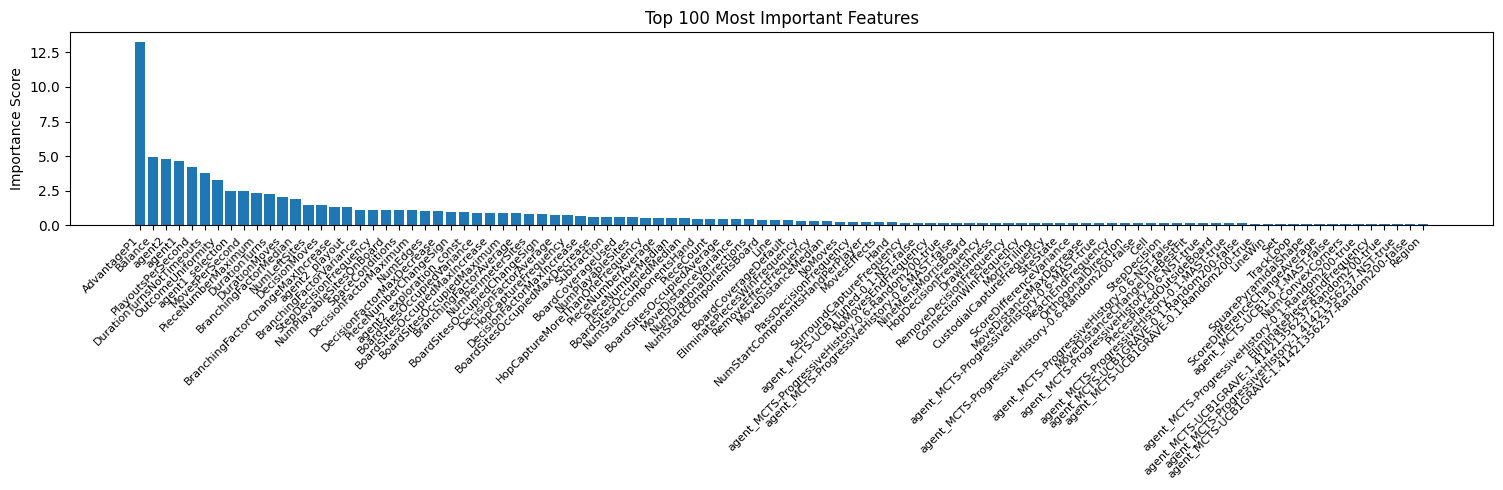

Fold 3 - RMSE: 0.4238453738649166
Fold 4


0:	learn: 0.6041542	test: 0.5984427	best: 0.5984427 (0)	total: 75.2ms	remaining: 3m 45s


50:	learn: 0.3998283	test: 0.4851880	best: 0.4851880 (50)	total: 4.23s	remaining: 4m 4s


100:	learn: 0.3623399	test: 0.4628810	best: 0.4626868 (99)	total: 8.6s	remaining: 4m 6s


150:	learn: 0.3424391	test: 0.4567195	best: 0.4566778 (148)	total: 12.9s	remaining: 4m 3s


200:	learn: 0.3278667	test: 0.4529073	best: 0.4529073 (200)	total: 17.2s	remaining: 3m 59s


250:	learn: 0.3176500	test: 0.4503116	best: 0.4502735 (248)	total: 21.6s	remaining: 3m 56s


300:	learn: 0.3084293	test: 0.4487382	best: 0.4487382 (300)	total: 26s	remaining: 3m 53s


350:	learn: 0.3005981	test: 0.4471312	best: 0.4471312 (350)	total: 30.3s	remaining: 3m 48s


400:	learn: 0.2941695	test: 0.4458663	best: 0.4458663 (400)	total: 34.6s	remaining: 3m 44s


450:	learn: 0.2882144	test: 0.4448184	best: 0.4448022 (449)	total: 39s	remaining: 3m 40s


500:	learn: 0.2828215	test: 0.4437185	best: 0.4437020 (498)	total: 43.3s	remaining: 3m 36s


550:	learn: 0.2784727	test: 0.4430050	best: 0.4429897 (549)	total: 47.7s	remaining: 3m 32s


600:	learn: 0.2741438	test: 0.4426759	best: 0.4426361 (594)	total: 52.1s	remaining: 3m 28s


650:	learn: 0.2702251	test: 0.4417786	best: 0.4417786 (650)	total: 56.5s	remaining: 3m 23s


700:	learn: 0.2665444	test: 0.4411346	best: 0.4411346 (700)	total: 1m	remaining: 3m 19s


750:	learn: 0.2633318	test: 0.4404266	best: 0.4404266 (750)	total: 1m 5s	remaining: 3m 15s


800:	learn: 0.2603662	test: 0.4402129	best: 0.4401978 (798)	total: 1m 9s	remaining: 3m 11s


850:	learn: 0.2576047	test: 0.4397025	best: 0.4397013 (843)	total: 1m 14s	remaining: 3m 7s


900:	learn: 0.2548211	test: 0.4394958	best: 0.4394948 (897)	total: 1m 18s	remaining: 3m 3s


950:	learn: 0.2523321	test: 0.4390628	best: 0.4390628 (950)	total: 1m 23s	remaining: 2m 58s


1000:	learn: 0.2498178	test: 0.4388627	best: 0.4388627 (1000)	total: 1m 27s	remaining: 2m 54s


1050:	learn: 0.2472778	test: 0.4386890	best: 0.4386725 (1044)	total: 1m 31s	remaining: 2m 50s


1100:	learn: 0.2449226	test: 0.4384108	best: 0.4383889 (1098)	total: 1m 36s	remaining: 2m 46s


1150:	learn: 0.2426886	test: 0.4382588	best: 0.4382588 (1150)	total: 1m 40s	remaining: 2m 41s


1200:	learn: 0.2405357	test: 0.4382656	best: 0.4381218 (1173)	total: 1m 45s	remaining: 2m 37s


1250:	learn: 0.2386115	test: 0.4381202	best: 0.4381202 (1250)	total: 1m 49s	remaining: 2m 33s


1300:	learn: 0.2365593	test: 0.4379899	best: 0.4379550 (1298)	total: 1m 54s	remaining: 2m 29s


1350:	learn: 0.2343450	test: 0.4377874	best: 0.4377874 (1350)	total: 1m 58s	remaining: 2m 24s


1400:	learn: 0.2326623	test: 0.4377696	best: 0.4377577 (1367)	total: 2m 3s	remaining: 2m 20s


1450:	learn: 0.2306771	test: 0.4375253	best: 0.4375253 (1450)	total: 2m 7s	remaining: 2m 16s


1500:	learn: 0.2287412	test: 0.4373017	best: 0.4373001 (1492)	total: 2m 11s	remaining: 2m 11s


1550:	learn: 0.2269193	test: 0.4372723	best: 0.4372723 (1550)	total: 2m 16s	remaining: 2m 7s


1600:	learn: 0.2249322	test: 0.4370493	best: 0.4370438 (1595)	total: 2m 20s	remaining: 2m 3s


1650:	learn: 0.2234069	test: 0.4370038	best: 0.4369766 (1632)	total: 2m 25s	remaining: 1m 58s


1700:	learn: 0.2217832	test: 0.4368860	best: 0.4368860 (1700)	total: 2m 29s	remaining: 1m 54s


1750:	learn: 0.2202374	test: 0.4367762	best: 0.4367762 (1750)	total: 2m 34s	remaining: 1m 50s


1800:	learn: 0.2187226	test: 0.4365972	best: 0.4365926 (1797)	total: 2m 38s	remaining: 1m 45s


1850:	learn: 0.2172778	test: 0.4364177	best: 0.4364131 (1849)	total: 2m 43s	remaining: 1m 41s


1900:	learn: 0.2156582	test: 0.4363559	best: 0.4363475 (1899)	total: 2m 47s	remaining: 1m 36s


1950:	learn: 0.2141094	test: 0.4363119	best: 0.4363119 (1950)	total: 2m 52s	remaining: 1m 32s


2000:	learn: 0.2125897	test: 0.4363308	best: 0.4362727 (1961)	total: 2m 56s	remaining: 1m 28s


2050:	learn: 0.2112979	test: 0.4362717	best: 0.4362715 (2049)	total: 3m 1s	remaining: 1m 23s


2100:	learn: 0.2097831	test: 0.4361837	best: 0.4361837 (2100)	total: 3m 5s	remaining: 1m 19s


2150:	learn: 0.2082869	test: 0.4362069	best: 0.4361631 (2125)	total: 3m 10s	remaining: 1m 15s


2200:	learn: 0.2068405	test: 0.4361779	best: 0.4361132 (2187)	total: 3m 14s	remaining: 1m 10s


2250:	learn: 0.2054639	test: 0.4362243	best: 0.4361132 (2187)	total: 3m 19s	remaining: 1m 6s


2300:	learn: 0.2042279	test: 0.4361487	best: 0.4361132 (2187)	total: 3m 23s	remaining: 1m 1s


2350:	learn: 0.2028428	test: 0.4361426	best: 0.4361132 (2187)	total: 3m 28s	remaining: 57.5s


2400:	learn: 0.2014803	test: 0.4361862	best: 0.4361132 (2187)	total: 3m 32s	remaining: 53s


2450:	learn: 0.2002225	test: 0.4361496	best: 0.4361132 (2187)	total: 3m 37s	remaining: 48.6s


2500:	learn: 0.1989331	test: 0.4361057	best: 0.4361017 (2479)	total: 3m 41s	remaining: 44.2s


2550:	learn: 0.1977221	test: 0.4360333	best: 0.4360283 (2546)	total: 3m 46s	remaining: 39.8s


2600:	learn: 0.1963950	test: 0.4360490	best: 0.4360123 (2589)	total: 3m 50s	remaining: 35.3s


2650:	learn: 0.1951977	test: 0.4360524	best: 0.4360059 (2627)	total: 3m 55s	remaining: 30.9s


2700:	learn: 0.1939845	test: 0.4359738	best: 0.4359729 (2699)	total: 3m 59s	remaining: 26.5s


2750:	learn: 0.1927695	test: 0.4359083	best: 0.4359083 (2750)	total: 4m 4s	remaining: 22.1s


2800:	learn: 0.1915957	test: 0.4358904	best: 0.4358788 (2786)	total: 4m 8s	remaining: 17.7s


2850:	learn: 0.1905351	test: 0.4359137	best: 0.4358788 (2786)	total: 4m 12s	remaining: 13.2s


2900:	learn: 0.1893831	test: 0.4359549	best: 0.4358788 (2786)	total: 4m 17s	remaining: 8.78s


2950:	learn: 0.1882466	test: 0.4360336	best: 0.4358788 (2786)	total: 4m 21s	remaining: 4.35s


2999:	learn: 0.1872128	test: 0.4360430	best: 0.4358788 (2786)	total: 4m 26s	remaining: 0us

bestTest = 0.43587878
bestIteration = 2786

Shrink model to first 2787 iterations.


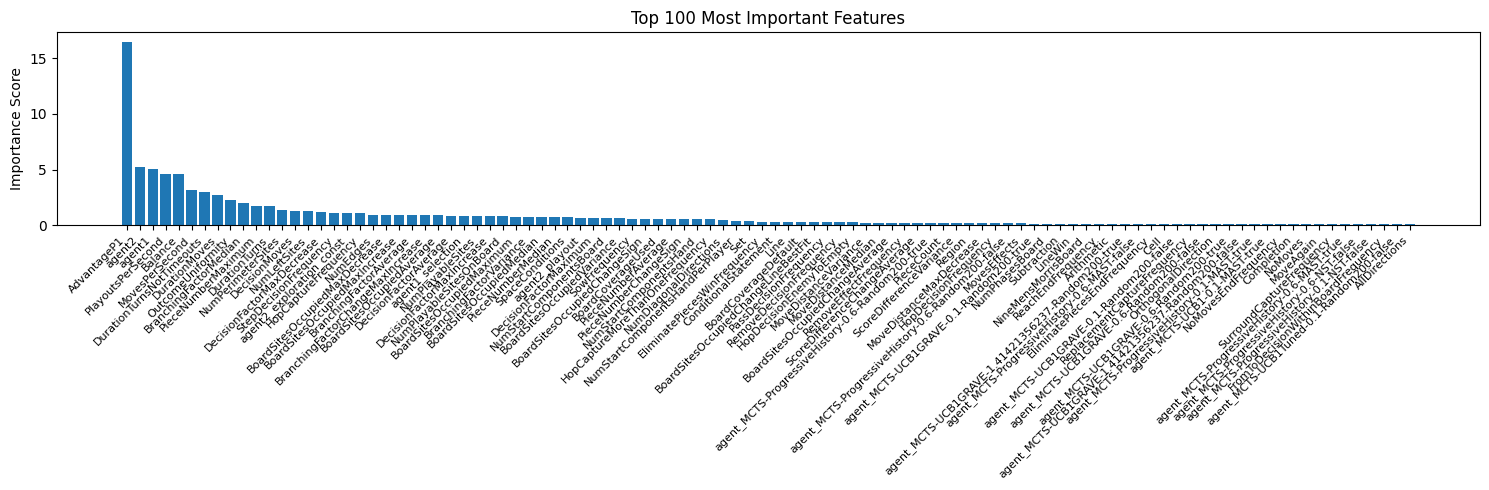

Fold 4 - RMSE: 0.4353629451101476
Fold 5


0:	learn: 0.6047564	test: 0.5865375	best: 0.5865375 (0)	total: 66.5ms	remaining: 3m 19s


50:	learn: 0.3922552	test: 0.4792350	best: 0.4792350 (50)	total: 4.17s	remaining: 4m 1s


100:	learn: 0.3574070	test: 0.4585651	best: 0.4585515 (99)	total: 8.5s	remaining: 4m 3s


150:	learn: 0.3369488	test: 0.4490087	best: 0.4490087 (150)	total: 12.8s	remaining: 4m 1s


200:	learn: 0.3234770	test: 0.4441280	best: 0.4441280 (200)	total: 17.2s	remaining: 3m 58s


250:	learn: 0.3117615	test: 0.4397424	best: 0.4397424 (250)	total: 21.5s	remaining: 3m 55s


300:	learn: 0.3034839	test: 0.4380988	best: 0.4380988 (300)	total: 25.9s	remaining: 3m 51s


350:	learn: 0.2967087	test: 0.4361057	best: 0.4361057 (350)	total: 30.2s	remaining: 3m 48s


400:	learn: 0.2910385	test: 0.4348798	best: 0.4348798 (400)	total: 34.6s	remaining: 3m 44s


450:	learn: 0.2859755	test: 0.4338507	best: 0.4338507 (450)	total: 38.9s	remaining: 3m 40s


500:	learn: 0.2811119	test: 0.4330393	best: 0.4329902 (498)	total: 43.4s	remaining: 3m 36s


550:	learn: 0.2769303	test: 0.4322769	best: 0.4322769 (550)	total: 47.8s	remaining: 3m 32s


600:	learn: 0.2724652	test: 0.4312774	best: 0.4312774 (600)	total: 52.1s	remaining: 3m 28s


650:	learn: 0.2687876	test: 0.4308076	best: 0.4308076 (650)	total: 56.5s	remaining: 3m 23s


700:	learn: 0.2653858	test: 0.4303467	best: 0.4303467 (700)	total: 1m	remaining: 3m 19s


750:	learn: 0.2618173	test: 0.4298770	best: 0.4298770 (750)	total: 1m 5s	remaining: 3m 15s


800:	learn: 0.2589008	test: 0.4296554	best: 0.4296554 (800)	total: 1m 9s	remaining: 3m 11s


850:	learn: 0.2559948	test: 0.4294257	best: 0.4293973 (842)	total: 1m 13s	remaining: 3m 6s


900:	learn: 0.2531735	test: 0.4291122	best: 0.4291043 (899)	total: 1m 18s	remaining: 3m 2s


950:	learn: 0.2506565	test: 0.4287125	best: 0.4287125 (950)	total: 1m 22s	remaining: 2m 57s


1000:	learn: 0.2480340	test: 0.4282512	best: 0.4282494 (999)	total: 1m 26s	remaining: 2m 53s


1050:	learn: 0.2457322	test: 0.4281514	best: 0.4281235 (1032)	total: 1m 31s	remaining: 2m 49s


1100:	learn: 0.2434348	test: 0.4279119	best: 0.4279027 (1099)	total: 1m 35s	remaining: 2m 45s


1150:	learn: 0.2410696	test: 0.4276976	best: 0.4276894 (1148)	total: 1m 39s	remaining: 2m 40s


1200:	learn: 0.2387813	test: 0.4273816	best: 0.4273816 (1200)	total: 1m 44s	remaining: 2m 36s


1250:	learn: 0.2365633	test: 0.4271973	best: 0.4271826 (1239)	total: 1m 48s	remaining: 2m 31s


1300:	learn: 0.2344370	test: 0.4271083	best: 0.4271083 (1300)	total: 1m 53s	remaining: 2m 27s


1350:	learn: 0.2326740	test: 0.4269500	best: 0.4269500 (1350)	total: 1m 57s	remaining: 2m 23s


1400:	learn: 0.2305817	test: 0.4266833	best: 0.4266699 (1398)	total: 2m 1s	remaining: 2m 18s


1450:	learn: 0.2287338	test: 0.4266278	best: 0.4266086 (1440)	total: 2m 5s	remaining: 2m 14s


1500:	learn: 0.2270235	test: 0.4265631	best: 0.4265160 (1479)	total: 2m 10s	remaining: 2m 10s


1550:	learn: 0.2253576	test: 0.4264312	best: 0.4264312 (1550)	total: 2m 14s	remaining: 2m 5s


1600:	learn: 0.2236884	test: 0.4263578	best: 0.4263534 (1594)	total: 2m 19s	remaining: 2m 1s


1650:	learn: 0.2220125	test: 0.4262418	best: 0.4262418 (1650)	total: 2m 23s	remaining: 1m 57s


1700:	learn: 0.2203159	test: 0.4260838	best: 0.4260735 (1688)	total: 2m 27s	remaining: 1m 52s


1750:	learn: 0.2187314	test: 0.4261045	best: 0.4260609 (1704)	total: 2m 31s	remaining: 1m 48s


1800:	learn: 0.2170193	test: 0.4261257	best: 0.4260609 (1704)	total: 2m 35s	remaining: 1m 43s


1850:	learn: 0.2154226	test: 0.4260041	best: 0.4259791 (1847)	total: 2m 40s	remaining: 1m 39s


1900:	learn: 0.2138821	test: 0.4259860	best: 0.4259659 (1886)	total: 2m 44s	remaining: 1m 35s


1950:	learn: 0.2125042	test: 0.4259424	best: 0.4259199 (1928)	total: 2m 48s	remaining: 1m 30s


2000:	learn: 0.2110924	test: 0.4258368	best: 0.4258144 (1990)	total: 2m 53s	remaining: 1m 26s


2050:	learn: 0.2096589	test: 0.4257104	best: 0.4257100 (2049)	total: 2m 57s	remaining: 1m 22s


2100:	learn: 0.2082368	test: 0.4256829	best: 0.4256829 (2100)	total: 3m 1s	remaining: 1m 17s


2150:	learn: 0.2068370	test: 0.4256593	best: 0.4256531 (2148)	total: 3m 5s	remaining: 1m 13s


2200:	learn: 0.2053547	test: 0.4257042	best: 0.4256531 (2148)	total: 3m 10s	remaining: 1m 8s


2250:	learn: 0.2037882	test: 0.4256716	best: 0.4256531 (2148)	total: 3m 14s	remaining: 1m 4s


2300:	learn: 0.2024559	test: 0.4256446	best: 0.4256446 (2300)	total: 3m 18s	remaining: 1m


2350:	learn: 0.2010931	test: 0.4255446	best: 0.4255404 (2349)	total: 3m 22s	remaining: 56s


2400:	learn: 0.1996566	test: 0.4256062	best: 0.4255404 (2349)	total: 3m 26s	remaining: 51.6s


2450:	learn: 0.1984742	test: 0.4255382	best: 0.4255305 (2444)	total: 3m 31s	remaining: 47.3s


2500:	learn: 0.1972867	test: 0.4254450	best: 0.4254405 (2497)	total: 3m 35s	remaining: 43s


2550:	learn: 0.1960237	test: 0.4254558	best: 0.4254120 (2515)	total: 3m 39s	remaining: 38.6s


2600:	learn: 0.1947866	test: 0.4254629	best: 0.4253853 (2560)	total: 3m 43s	remaining: 34.3s


2650:	learn: 0.1936514	test: 0.4254493	best: 0.4253853 (2560)	total: 3m 48s	remaining: 30s


2700:	learn: 0.1925012	test: 0.4254436	best: 0.4253853 (2560)	total: 3m 52s	remaining: 25.7s


2750:	learn: 0.1914193	test: 0.4253973	best: 0.4253853 (2560)	total: 3m 56s	remaining: 21.4s


2800:	learn: 0.1902099	test: 0.4253758	best: 0.4253657 (2762)	total: 4m	remaining: 17.1s


2850:	learn: 0.1890703	test: 0.4253177	best: 0.4253177 (2850)	total: 4m 4s	remaining: 12.8s


2900:	learn: 0.1879841	test: 0.4252573	best: 0.4252573 (2900)	total: 4m 9s	remaining: 8.5s


2950:	learn: 0.1868407	test: 0.4251578	best: 0.4251529 (2948)	total: 4m 13s	remaining: 4.2s


2999:	learn: 0.1858569	test: 0.4251840	best: 0.4251428 (2954)	total: 4m 17s	remaining: 0us

bestTest = 0.4251428403
bestIteration = 2954

Shrink model to first 2955 iterations.


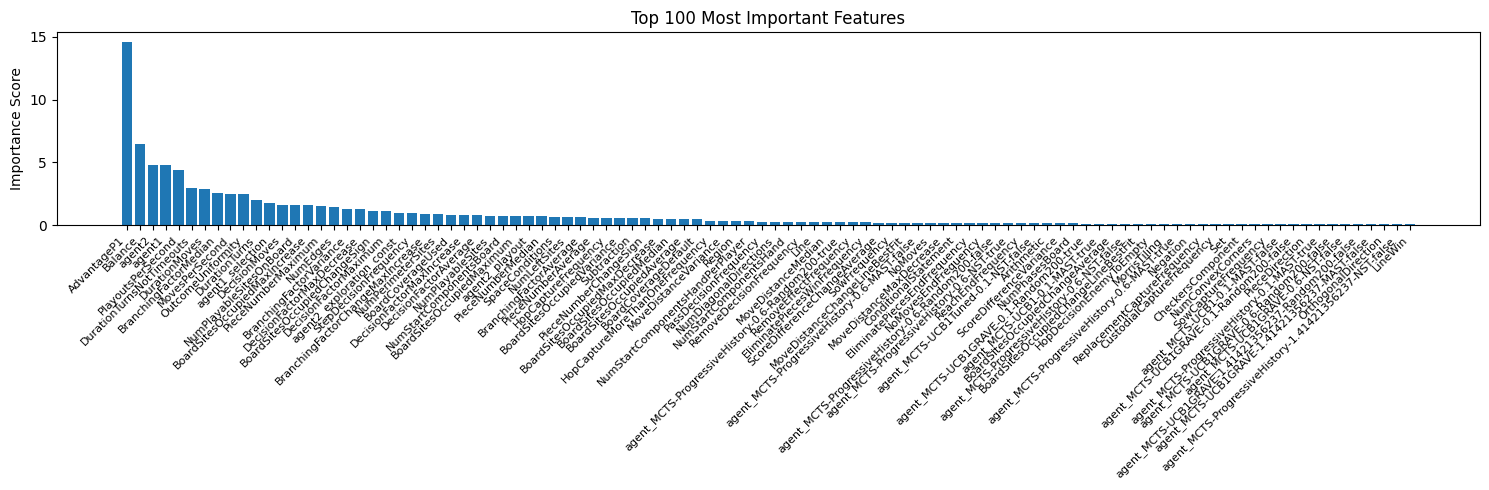

Fold 5 - RMSE: 0.4244730508962132
List of oof scores: [0.40519543005117914, 0.39805751261528893, 0.4238453738649166, 0.4353629451101476, 0.4244730508962132]
Average oof score: 0.41738686250754914


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6090498	test: 0.5668211	best: 0.5668211 (0)	total: 62.6ms	remaining: 3m 7s


50:	learn: 0.3973200	test: 0.4702873	best: 0.4702873 (50)	total: 3.88s	remaining: 3m 44s


100:	learn: 0.3601024	test: 0.4515293	best: 0.4515293 (100)	total: 7.91s	remaining: 3m 47s


150:	learn: 0.3388646	test: 0.4455513	best: 0.4455513 (150)	total: 12s	remaining: 3m 45s


200:	learn: 0.3259418	test: 0.4425363	best: 0.4425363 (200)	total: 16s	remaining: 3m 42s


250:	learn: 0.3149859	test: 0.4396352	best: 0.4396352 (250)	total: 20s	remaining: 3m 39s


300:	learn: 0.3068737	test: 0.4373283	best: 0.4373283 (300)	total: 24.1s	remaining: 3m 36s


350:	learn: 0.3000562	test: 0.4361627	best: 0.4360970 (347)	total: 28.2s	remaining: 3m 32s


400:	learn: 0.2934919	test: 0.4353899	best: 0.4353542 (389)	total: 32.2s	remaining: 3m 28s


450:	learn: 0.2880869	test: 0.4348598	best: 0.4348598 (450)	total: 36.3s	remaining: 3m 25s


500:	learn: 0.2831089	test: 0.4339509	best: 0.4339509 (500)	total: 40.4s	remaining: 3m 21s


550:	learn: 0.2787837	test: 0.4333399	best: 0.4333399 (550)	total: 44.4s	remaining: 3m 17s


600:	learn: 0.2747623	test: 0.4328708	best: 0.4328708 (600)	total: 48.5s	remaining: 3m 13s


650:	learn: 0.2706072	test: 0.4320518	best: 0.4320518 (650)	total: 52.6s	remaining: 3m 9s


700:	learn: 0.2665155	test: 0.4316901	best: 0.4316901 (700)	total: 56.7s	remaining: 3m 5s


750:	learn: 0.2633086	test: 0.4314199	best: 0.4314199 (750)	total: 1m	remaining: 3m 2s


800:	learn: 0.2601636	test: 0.4311238	best: 0.4310690 (791)	total: 1m 4s	remaining: 2m 58s


850:	learn: 0.2573045	test: 0.4308024	best: 0.4308024 (850)	total: 1m 9s	remaining: 2m 54s


900:	learn: 0.2543000	test: 0.4306322	best: 0.4305511 (886)	total: 1m 13s	remaining: 2m 50s


950:	learn: 0.2514419	test: 0.4304585	best: 0.4304288 (922)	total: 1m 17s	remaining: 2m 46s


1000:	learn: 0.2489376	test: 0.4302465	best: 0.4302221 (996)	total: 1m 21s	remaining: 2m 42s


1050:	learn: 0.2465339	test: 0.4301548	best: 0.4301024 (1048)	total: 1m 25s	remaining: 2m 38s


1100:	learn: 0.2441563	test: 0.4297020	best: 0.4296862 (1099)	total: 1m 29s	remaining: 2m 34s


1150:	learn: 0.2419817	test: 0.4295898	best: 0.4295423 (1144)	total: 1m 33s	remaining: 2m 30s


1200:	learn: 0.2397694	test: 0.4293523	best: 0.4293523 (1200)	total: 1m 38s	remaining: 2m 26s


1250:	learn: 0.2375992	test: 0.4293783	best: 0.4292467 (1220)	total: 1m 42s	remaining: 2m 22s


1300:	learn: 0.2355289	test: 0.4292425	best: 0.4292081 (1295)	total: 1m 46s	remaining: 2m 19s


1350:	learn: 0.2335470	test: 0.4292620	best: 0.4292081 (1295)	total: 1m 50s	remaining: 2m 14s


1400:	learn: 0.2317306	test: 0.4293720	best: 0.4292081 (1295)	total: 1m 54s	remaining: 2m 10s


1450:	learn: 0.2296155	test: 0.4291916	best: 0.4291907 (1449)	total: 1m 58s	remaining: 2m 6s


1500:	learn: 0.2277804	test: 0.4291363	best: 0.4291363 (1500)	total: 2m 2s	remaining: 2m 2s


1550:	learn: 0.2260077	test: 0.4290244	best: 0.4290232 (1545)	total: 2m 7s	remaining: 1m 58s


1600:	learn: 0.2242187	test: 0.4289222	best: 0.4289102 (1595)	total: 2m 11s	remaining: 1m 54s


1650:	learn: 0.2225850	test: 0.4287941	best: 0.4287887 (1649)	total: 2m 15s	remaining: 1m 50s


1700:	learn: 0.2209757	test: 0.4287159	best: 0.4287159 (1700)	total: 2m 19s	remaining: 1m 46s


1750:	learn: 0.2193778	test: 0.4286691	best: 0.4286691 (1750)	total: 2m 23s	remaining: 1m 42s


1800:	learn: 0.2178613	test: 0.4286237	best: 0.4286185 (1797)	total: 2m 27s	remaining: 1m 38s


1850:	learn: 0.2162845	test: 0.4285522	best: 0.4285477 (1847)	total: 2m 32s	remaining: 1m 34s


1900:	learn: 0.2148297	test: 0.4284304	best: 0.4284166 (1895)	total: 2m 36s	remaining: 1m 30s


1950:	learn: 0.2135373	test: 0.4284344	best: 0.4284093 (1943)	total: 2m 40s	remaining: 1m 26s


2000:	learn: 0.2121125	test: 0.4283981	best: 0.4283898 (1997)	total: 2m 44s	remaining: 1m 22s


2050:	learn: 0.2106144	test: 0.4284243	best: 0.4283747 (2021)	total: 2m 48s	remaining: 1m 18s


2100:	learn: 0.2092150	test: 0.4283810	best: 0.4283517 (2094)	total: 2m 52s	remaining: 1m 13s


2150:	learn: 0.2079079	test: 0.4283896	best: 0.4283517 (2094)	total: 2m 56s	remaining: 1m 9s


2200:	learn: 0.2065591	test: 0.4284611	best: 0.4283517 (2094)	total: 3m 1s	remaining: 1m 5s


2250:	learn: 0.2053000	test: 0.4285986	best: 0.4283517 (2094)	total: 3m 5s	remaining: 1m 1s


2300:	learn: 0.2039830	test: 0.4285699	best: 0.4283517 (2094)	total: 3m 9s	remaining: 57.5s


2350:	learn: 0.2027714	test: 0.4285420	best: 0.4283517 (2094)	total: 3m 13s	remaining: 53.4s


2400:	learn: 0.2015869	test: 0.4285331	best: 0.4283517 (2094)	total: 3m 17s	remaining: 49.3s


2450:	learn: 0.2002843	test: 0.4285321	best: 0.4283517 (2094)	total: 3m 21s	remaining: 45.2s


2500:	learn: 0.1990818	test: 0.4285375	best: 0.4283517 (2094)	total: 3m 25s	remaining: 41.1s


2550:	learn: 0.1978553	test: 0.4285537	best: 0.4283517 (2094)	total: 3m 30s	remaining: 37s


2600:	learn: 0.1966798	test: 0.4285134	best: 0.4283517 (2094)	total: 3m 34s	remaining: 32.9s


2650:	learn: 0.1954647	test: 0.4284228	best: 0.4283517 (2094)	total: 3m 38s	remaining: 28.7s


2700:	learn: 0.1942091	test: 0.4284121	best: 0.4283517 (2094)	total: 3m 42s	remaining: 24.6s


2750:	learn: 0.1929975	test: 0.4283580	best: 0.4283384 (2742)	total: 3m 46s	remaining: 20.5s


2800:	learn: 0.1917734	test: 0.4284381	best: 0.4283384 (2742)	total: 3m 50s	remaining: 16.4s


2850:	learn: 0.1906921	test: 0.4284688	best: 0.4283384 (2742)	total: 3m 54s	remaining: 12.3s


2900:	learn: 0.1895486	test: 0.4285155	best: 0.4283384 (2742)	total: 3m 59s	remaining: 8.16s


2950:	learn: 0.1883786	test: 0.4284555	best: 0.4283384 (2742)	total: 4m 3s	remaining: 4.04s


2999:	learn: 0.1871917	test: 0.4284941	best: 0.4283384 (2742)	total: 4m 7s	remaining: 0us

bestTest = 0.4283384186
bestIteration = 2742

Shrink model to first 2743 iterations.


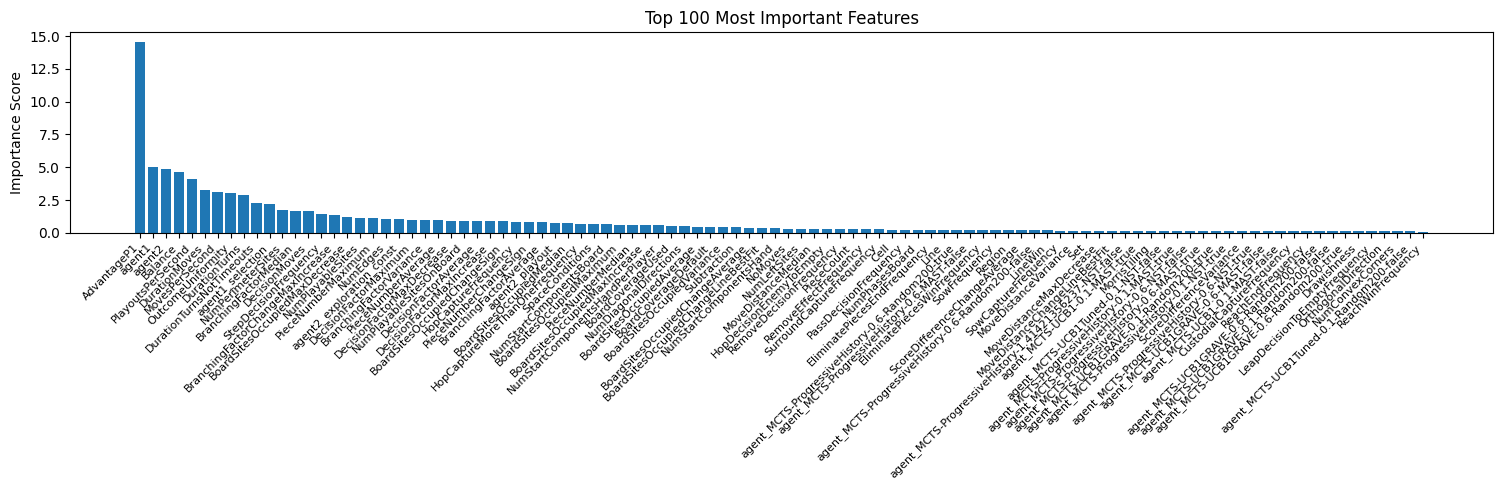

Fold 1 - RMSE: 0.4279658345933993
Fold 2


0:	learn: 0.6074335	test: 0.5689627	best: 0.5689627 (0)	total: 71.9ms	remaining: 3m 35s


50:	learn: 0.3978187	test: 0.4648071	best: 0.4648071 (50)	total: 3.95s	remaining: 3m 48s


100:	learn: 0.3608247	test: 0.4422651	best: 0.4422366 (99)	total: 8.04s	remaining: 3m 50s


150:	learn: 0.3396303	test: 0.4349373	best: 0.4349288 (149)	total: 12s	remaining: 3m 47s


200:	learn: 0.3258777	test: 0.4290823	best: 0.4290823 (200)	total: 16.1s	remaining: 3m 44s


250:	learn: 0.3142715	test: 0.4256297	best: 0.4256297 (250)	total: 20.2s	remaining: 3m 41s


300:	learn: 0.3063767	test: 0.4231163	best: 0.4231163 (300)	total: 24.3s	remaining: 3m 37s


350:	learn: 0.2991351	test: 0.4214663	best: 0.4214663 (350)	total: 28.4s	remaining: 3m 34s


400:	learn: 0.2923430	test: 0.4201230	best: 0.4201230 (400)	total: 32.5s	remaining: 3m 30s


450:	learn: 0.2864221	test: 0.4187806	best: 0.4187806 (450)	total: 36.5s	remaining: 3m 26s


500:	learn: 0.2817956	test: 0.4178631	best: 0.4178631 (500)	total: 40.7s	remaining: 3m 22s


550:	learn: 0.2769296	test: 0.4172132	best: 0.4172132 (550)	total: 44.8s	remaining: 3m 19s


600:	learn: 0.2728285	test: 0.4162331	best: 0.4162331 (600)	total: 49s	remaining: 3m 15s


650:	learn: 0.2689317	test: 0.4155266	best: 0.4155266 (650)	total: 53.1s	remaining: 3m 11s


700:	learn: 0.2653405	test: 0.4151544	best: 0.4151544 (700)	total: 57.3s	remaining: 3m 7s


750:	learn: 0.2619384	test: 0.4146156	best: 0.4146147 (749)	total: 1m 1s	remaining: 3m 3s


800:	learn: 0.2587935	test: 0.4140149	best: 0.4140149 (800)	total: 1m 5s	remaining: 3m


850:	learn: 0.2560011	test: 0.4136368	best: 0.4136368 (850)	total: 1m 9s	remaining: 2m 56s


900:	learn: 0.2533592	test: 0.4131917	best: 0.4131917 (900)	total: 1m 14s	remaining: 2m 52s


950:	learn: 0.2507920	test: 0.4128375	best: 0.4128375 (950)	total: 1m 18s	remaining: 2m 48s


1000:	learn: 0.2483508	test: 0.4125614	best: 0.4125536 (996)	total: 1m 22s	remaining: 2m 44s


1050:	learn: 0.2459570	test: 0.4120578	best: 0.4120578 (1050)	total: 1m 26s	remaining: 2m 41s


1100:	learn: 0.2436083	test: 0.4117973	best: 0.4117791 (1092)	total: 1m 31s	remaining: 2m 37s


1150:	learn: 0.2415138	test: 0.4117212	best: 0.4117202 (1149)	total: 1m 35s	remaining: 2m 33s


1200:	learn: 0.2394225	test: 0.4114344	best: 0.4114344 (1200)	total: 1m 39s	remaining: 2m 29s


1250:	learn: 0.2373490	test: 0.4113196	best: 0.4113124 (1248)	total: 1m 44s	remaining: 2m 25s


1300:	learn: 0.2353605	test: 0.4110797	best: 0.4110716 (1297)	total: 1m 48s	remaining: 2m 21s


1350:	learn: 0.2333790	test: 0.4108522	best: 0.4108371 (1346)	total: 1m 52s	remaining: 2m 17s


1400:	learn: 0.2313326	test: 0.4107056	best: 0.4106946 (1397)	total: 1m 56s	remaining: 2m 13s


1450:	learn: 0.2292828	test: 0.4105174	best: 0.4105174 (1450)	total: 2m 1s	remaining: 2m 9s


1500:	learn: 0.2273612	test: 0.4103994	best: 0.4103845 (1495)	total: 2m 5s	remaining: 2m 5s


1550:	learn: 0.2257545	test: 0.4103264	best: 0.4102830 (1544)	total: 2m 9s	remaining: 2m 1s


1600:	learn: 0.2241101	test: 0.4102187	best: 0.4102012 (1583)	total: 2m 14s	remaining: 1m 57s


1650:	learn: 0.2223573	test: 0.4100708	best: 0.4100534 (1640)	total: 2m 18s	remaining: 1m 53s


1700:	learn: 0.2206086	test: 0.4098991	best: 0.4098846 (1698)	total: 2m 22s	remaining: 1m 49s


1750:	learn: 0.2190783	test: 0.4098182	best: 0.4097941 (1744)	total: 2m 27s	remaining: 1m 44s


1800:	learn: 0.2174979	test: 0.4097165	best: 0.4097102 (1799)	total: 2m 31s	remaining: 1m 40s


1850:	learn: 0.2160537	test: 0.4096990	best: 0.4096835 (1819)	total: 2m 35s	remaining: 1m 36s


1900:	learn: 0.2144752	test: 0.4097206	best: 0.4096835 (1819)	total: 2m 39s	remaining: 1m 32s


1950:	learn: 0.2130692	test: 0.4097105	best: 0.4096835 (1819)	total: 2m 44s	remaining: 1m 28s


2000:	learn: 0.2116161	test: 0.4097061	best: 0.4096835 (1819)	total: 2m 48s	remaining: 1m 24s


2050:	learn: 0.2102012	test: 0.4097451	best: 0.4096835 (1819)	total: 2m 52s	remaining: 1m 20s


2100:	learn: 0.2088292	test: 0.4096398	best: 0.4096398 (2100)	total: 2m 57s	remaining: 1m 15s


2150:	learn: 0.2074102	test: 0.4095602	best: 0.4095602 (2150)	total: 3m 1s	remaining: 1m 11s


2200:	learn: 0.2060515	test: 0.4094939	best: 0.4094939 (2200)	total: 3m 6s	remaining: 1m 7s


2250:	learn: 0.2045336	test: 0.4094381	best: 0.4094159 (2236)	total: 3m 10s	remaining: 1m 3s


2300:	learn: 0.2032887	test: 0.4094256	best: 0.4094159 (2236)	total: 3m 14s	remaining: 59.1s


2350:	learn: 0.2019905	test: 0.4093975	best: 0.4093969 (2317)	total: 3m 19s	remaining: 54.9s


2400:	learn: 0.2007232	test: 0.4093738	best: 0.4093554 (2359)	total: 3m 23s	remaining: 50.7s


2450:	learn: 0.1995947	test: 0.4093486	best: 0.4093480 (2449)	total: 3m 27s	remaining: 46.5s


2500:	learn: 0.1983619	test: 0.4093364	best: 0.4092879 (2468)	total: 3m 32s	remaining: 42.3s


2550:	learn: 0.1971046	test: 0.4093466	best: 0.4092879 (2468)	total: 3m 36s	remaining: 38.1s


2600:	learn: 0.1958625	test: 0.4094252	best: 0.4092879 (2468)	total: 3m 40s	remaining: 33.9s


2650:	learn: 0.1946977	test: 0.4093583	best: 0.4092879 (2468)	total: 3m 45s	remaining: 29.6s


2700:	learn: 0.1934394	test: 0.4092807	best: 0.4092734 (2685)	total: 3m 49s	remaining: 25.4s


2750:	learn: 0.1922340	test: 0.4092943	best: 0.4092734 (2685)	total: 3m 53s	remaining: 21.2s


2800:	learn: 0.1911032	test: 0.4092194	best: 0.4091985 (2794)	total: 3m 58s	remaining: 16.9s


2850:	learn: 0.1899075	test: 0.4092680	best: 0.4091985 (2794)	total: 4m 2s	remaining: 12.7s


2900:	learn: 0.1887549	test: 0.4092820	best: 0.4091985 (2794)	total: 4m 6s	remaining: 8.43s


2950:	learn: 0.1876487	test: 0.4092593	best: 0.4091985 (2794)	total: 4m 11s	remaining: 4.17s


2999:	learn: 0.1865489	test: 0.4092373	best: 0.4091985 (2794)	total: 4m 15s	remaining: 0us

bestTest = 0.4091985246
bestIteration = 2794

Shrink model to first 2795 iterations.


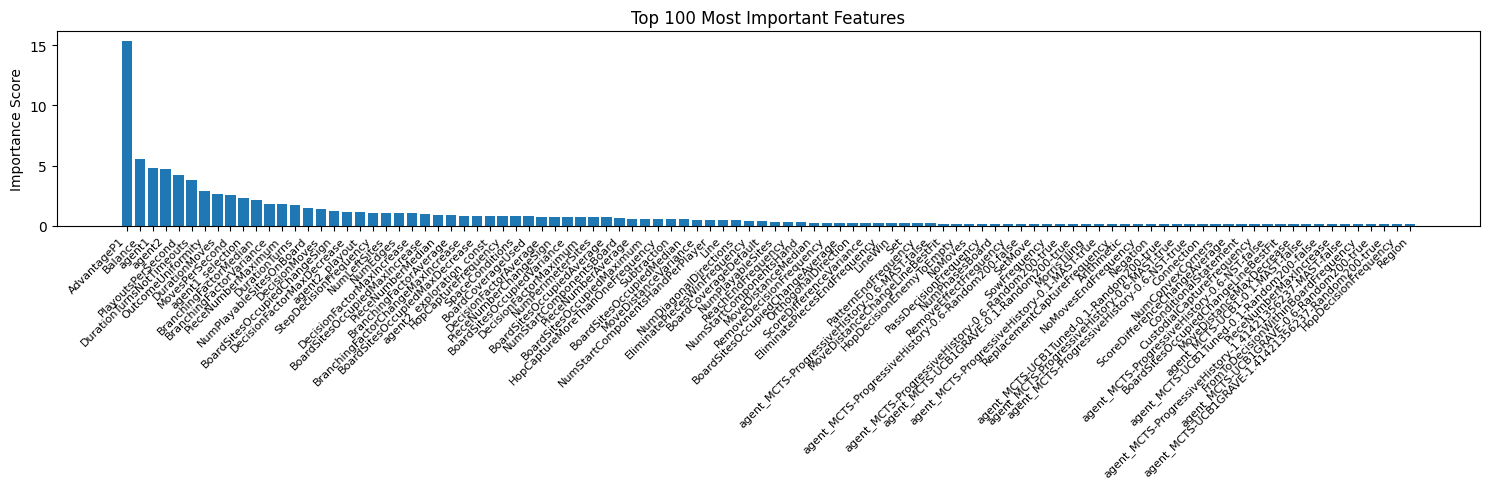

Fold 2 - RMSE: 0.4086844461740019
Fold 3


0:	learn: 0.6109814	test: 0.5704819	best: 0.5704819 (0)	total: 67.8ms	remaining: 3m 23s


50:	learn: 0.3950196	test: 0.4629268	best: 0.4628717 (49)	total: 3.89s	remaining: 3m 44s


100:	learn: 0.3581365	test: 0.4447602	best: 0.4447602 (100)	total: 8.04s	remaining: 3m 50s


150:	learn: 0.3392341	test: 0.4384013	best: 0.4384013 (150)	total: 12.1s	remaining: 3m 48s


200:	learn: 0.3248337	test: 0.4347641	best: 0.4347641 (200)	total: 16.3s	remaining: 3m 46s


250:	learn: 0.3146159	test: 0.4319085	best: 0.4319085 (250)	total: 20.4s	remaining: 3m 43s


300:	learn: 0.3064188	test: 0.4307713	best: 0.4307713 (300)	total: 24.6s	remaining: 3m 40s


350:	learn: 0.2994906	test: 0.4289619	best: 0.4289619 (350)	total: 28.8s	remaining: 3m 37s


400:	learn: 0.2934323	test: 0.4278027	best: 0.4278027 (400)	total: 33s	remaining: 3m 33s


450:	learn: 0.2879068	test: 0.4270386	best: 0.4270386 (450)	total: 37.2s	remaining: 3m 30s


500:	learn: 0.2824051	test: 0.4259792	best: 0.4259652 (497)	total: 41.4s	remaining: 3m 26s


550:	learn: 0.2778802	test: 0.4252921	best: 0.4252921 (550)	total: 45.5s	remaining: 3m 22s


600:	learn: 0.2735643	test: 0.4250388	best: 0.4250237 (586)	total: 49.7s	remaining: 3m 18s


650:	learn: 0.2697240	test: 0.4246911	best: 0.4246824 (646)	total: 54.5s	remaining: 3m 16s


700:	learn: 0.2660137	test: 0.4242862	best: 0.4242799 (699)	total: 58.6s	remaining: 3m 12s


750:	learn: 0.2624364	test: 0.4239406	best: 0.4238986 (738)	total: 1m 2s	remaining: 3m 8s


800:	learn: 0.2593994	test: 0.4234746	best: 0.4234746 (800)	total: 1m 7s	remaining: 3m 4s


850:	learn: 0.2562497	test: 0.4233432	best: 0.4232805 (845)	total: 1m 11s	remaining: 2m 59s


900:	learn: 0.2535846	test: 0.4230374	best: 0.4230269 (892)	total: 1m 15s	remaining: 2m 55s


950:	learn: 0.2509972	test: 0.4228245	best: 0.4228128 (933)	total: 1m 19s	remaining: 2m 51s


1000:	learn: 0.2483512	test: 0.4226070	best: 0.4226070 (1000)	total: 1m 23s	remaining: 2m 47s


1050:	learn: 0.2459456	test: 0.4222380	best: 0.4222150 (1046)	total: 1m 27s	remaining: 2m 43s


1100:	learn: 0.2435555	test: 0.4220158	best: 0.4220158 (1100)	total: 1m 31s	remaining: 2m 38s


1150:	learn: 0.2412978	test: 0.4218617	best: 0.4218568 (1149)	total: 1m 36s	remaining: 2m 34s


1200:	learn: 0.2388938	test: 0.4218520	best: 0.4218324 (1182)	total: 1m 40s	remaining: 2m 30s


1250:	learn: 0.2366468	test: 0.4217262	best: 0.4217004 (1236)	total: 1m 45s	remaining: 2m 27s


1300:	learn: 0.2343931	test: 0.4214428	best: 0.4214226 (1293)	total: 1m 49s	remaining: 2m 23s


1350:	learn: 0.2323308	test: 0.4213476	best: 0.4212800 (1339)	total: 1m 53s	remaining: 2m 18s


1400:	learn: 0.2303721	test: 0.4214157	best: 0.4212800 (1339)	total: 1m 57s	remaining: 2m 14s


1450:	learn: 0.2283454	test: 0.4212312	best: 0.4212108 (1441)	total: 2m 1s	remaining: 2m 10s


1500:	learn: 0.2266065	test: 0.4210657	best: 0.4210657 (1500)	total: 2m 5s	remaining: 2m 5s


1550:	learn: 0.2248140	test: 0.4210323	best: 0.4210233 (1547)	total: 2m 9s	remaining: 2m 1s


1600:	learn: 0.2231550	test: 0.4209491	best: 0.4209491 (1600)	total: 2m 14s	remaining: 1m 57s


1650:	learn: 0.2213880	test: 0.4208691	best: 0.4208545 (1625)	total: 2m 18s	remaining: 1m 53s


1700:	learn: 0.2195754	test: 0.4207136	best: 0.4206650 (1687)	total: 2m 22s	remaining: 1m 49s


1750:	learn: 0.2178585	test: 0.4205782	best: 0.4205509 (1744)	total: 2m 27s	remaining: 1m 44s


1800:	learn: 0.2161199	test: 0.4205117	best: 0.4205117 (1800)	total: 2m 31s	remaining: 1m 40s


1850:	learn: 0.2144203	test: 0.4204845	best: 0.4204743 (1822)	total: 2m 35s	remaining: 1m 36s


1900:	learn: 0.2126866	test: 0.4203398	best: 0.4203398 (1900)	total: 2m 39s	remaining: 1m 32s


1950:	learn: 0.2110409	test: 0.4202316	best: 0.4202316 (1950)	total: 2m 43s	remaining: 1m 27s


2000:	learn: 0.2095373	test: 0.4201500	best: 0.4201067 (1989)	total: 2m 47s	remaining: 1m 23s


2050:	learn: 0.2081627	test: 0.4200434	best: 0.4200434 (2050)	total: 2m 51s	remaining: 1m 19s


2100:	learn: 0.2067713	test: 0.4200363	best: 0.4200174 (2053)	total: 2m 55s	remaining: 1m 15s


2150:	learn: 0.2053465	test: 0.4199973	best: 0.4199973 (2150)	total: 3m	remaining: 1m 11s


2200:	learn: 0.2039310	test: 0.4199440	best: 0.4199064 (2174)	total: 3m 4s	remaining: 1m 6s


2250:	learn: 0.2024878	test: 0.4198964	best: 0.4198734 (2231)	total: 3m 8s	remaining: 1m 2s


2300:	learn: 0.2010745	test: 0.4198870	best: 0.4198506 (2290)	total: 3m 12s	remaining: 58.4s


2350:	learn: 0.1997270	test: 0.4198493	best: 0.4198490 (2349)	total: 3m 16s	remaining: 54.2s


2400:	learn: 0.1984397	test: 0.4198350	best: 0.4198310 (2353)	total: 3m 20s	remaining: 50s


2450:	learn: 0.1971226	test: 0.4198176	best: 0.4197955 (2418)	total: 3m 24s	remaining: 45.8s


2500:	learn: 0.1957914	test: 0.4198619	best: 0.4197889 (2456)	total: 3m 28s	remaining: 41.6s


2550:	learn: 0.1943876	test: 0.4197519	best: 0.4197362 (2529)	total: 3m 32s	remaining: 37.4s


2600:	learn: 0.1931959	test: 0.4196882	best: 0.4196861 (2596)	total: 3m 36s	remaining: 33.2s


2650:	learn: 0.1920955	test: 0.4196843	best: 0.4196667 (2619)	total: 3m 40s	remaining: 29s


2700:	learn: 0.1908564	test: 0.4196300	best: 0.4196300 (2700)	total: 3m 44s	remaining: 24.9s


2750:	learn: 0.1896195	test: 0.4195198	best: 0.4195143 (2746)	total: 3m 48s	remaining: 20.7s


2800:	learn: 0.1883922	test: 0.4195266	best: 0.4194966 (2785)	total: 3m 52s	remaining: 16.5s


2850:	learn: 0.1872446	test: 0.4195309	best: 0.4194966 (2785)	total: 3m 56s	remaining: 12.4s


2900:	learn: 0.1860759	test: 0.4195412	best: 0.4194966 (2785)	total: 4m	remaining: 8.22s


2950:	learn: 0.1849815	test: 0.4195412	best: 0.4194966 (2785)	total: 4m 4s	remaining: 4.07s


2999:	learn: 0.1838992	test: 0.4195219	best: 0.4194849 (2984)	total: 4m 8s	remaining: 0us

bestTest = 0.4194848974
bestIteration = 2984

Shrink model to first 2985 iterations.


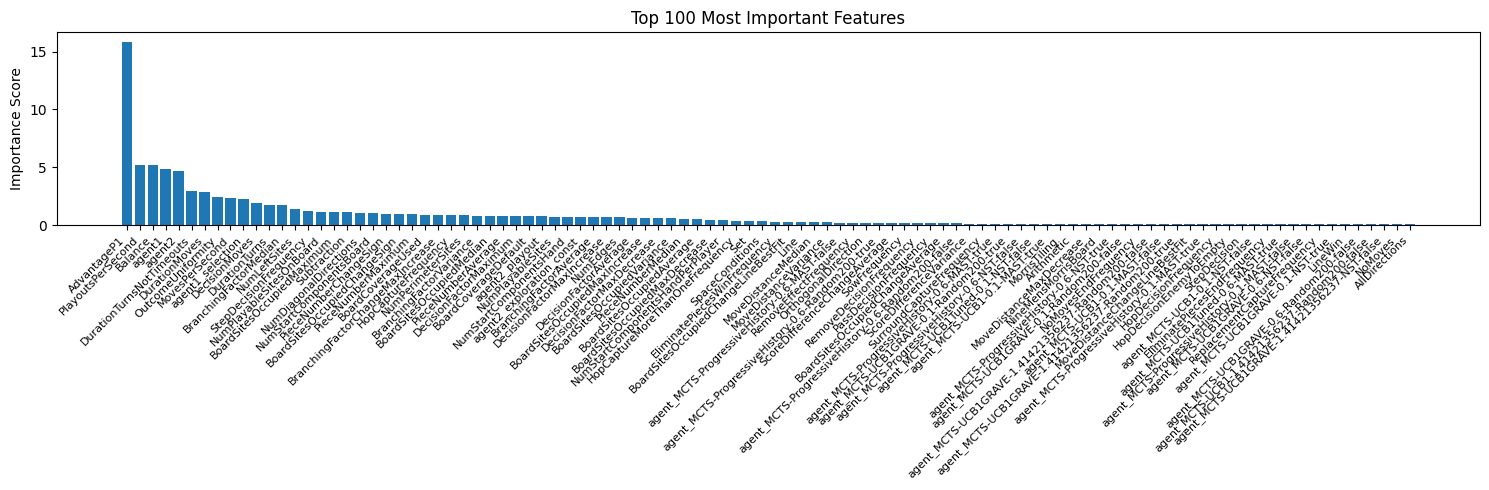

Fold 3 - RMSE: 0.4190443619477514
Fold 4


0:	learn: 0.6107918	test: 0.5648918	best: 0.5648918 (0)	total: 72.1ms	remaining: 3m 36s


50:	learn: 0.3964649	test: 0.4630030	best: 0.4630030 (50)	total: 3.74s	remaining: 3m 36s


100:	learn: 0.3583903	test: 0.4473925	best: 0.4473925 (100)	total: 7.66s	remaining: 3m 39s


150:	learn: 0.3378664	test: 0.4422340	best: 0.4422340 (150)	total: 11.6s	remaining: 3m 39s


200:	learn: 0.3240852	test: 0.4381874	best: 0.4381541 (199)	total: 15.6s	remaining: 3m 36s


250:	learn: 0.3133906	test: 0.4357031	best: 0.4357031 (250)	total: 19.5s	remaining: 3m 33s


300:	learn: 0.3054578	test: 0.4340512	best: 0.4340334 (299)	total: 23.4s	remaining: 3m 29s


350:	learn: 0.2979200	test: 0.4322493	best: 0.4322301 (349)	total: 27.4s	remaining: 3m 26s


400:	learn: 0.2913900	test: 0.4312761	best: 0.4312620 (398)	total: 31.3s	remaining: 3m 23s


450:	learn: 0.2855123	test: 0.4301158	best: 0.4301158 (450)	total: 35.3s	remaining: 3m 19s


500:	learn: 0.2805706	test: 0.4293916	best: 0.4293916 (500)	total: 39.3s	remaining: 3m 15s


550:	learn: 0.2761076	test: 0.4287165	best: 0.4287165 (550)	total: 43.2s	remaining: 3m 12s


600:	learn: 0.2718136	test: 0.4284692	best: 0.4284646 (592)	total: 47.2s	remaining: 3m 8s


650:	learn: 0.2680853	test: 0.4280870	best: 0.4280843 (649)	total: 51.2s	remaining: 3m 4s


700:	learn: 0.2647144	test: 0.4277106	best: 0.4276896 (698)	total: 55.2s	remaining: 3m


750:	learn: 0.2616681	test: 0.4271157	best: 0.4271157 (750)	total: 59.2s	remaining: 2m 57s


800:	learn: 0.2583033	test: 0.4266820	best: 0.4266820 (800)	total: 1m 3s	remaining: 2m 53s


850:	learn: 0.2554084	test: 0.4263633	best: 0.4263568 (844)	total: 1m 7s	remaining: 2m 49s


900:	learn: 0.2526967	test: 0.4261021	best: 0.4261021 (900)	total: 1m 11s	remaining: 2m 46s


950:	learn: 0.2498762	test: 0.4258647	best: 0.4258496 (946)	total: 1m 15s	remaining: 2m 41s


1000:	learn: 0.2473845	test: 0.4256660	best: 0.4256654 (998)	total: 1m 19s	remaining: 2m 38s


1050:	learn: 0.2449760	test: 0.4255312	best: 0.4255312 (1050)	total: 1m 23s	remaining: 2m 34s


1100:	learn: 0.2427564	test: 0.4254015	best: 0.4254015 (1100)	total: 1m 27s	remaining: 2m 30s


1150:	learn: 0.2403724	test: 0.4251524	best: 0.4251524 (1150)	total: 1m 31s	remaining: 2m 26s


1200:	learn: 0.2382803	test: 0.4250189	best: 0.4250148 (1199)	total: 1m 35s	remaining: 2m 22s


1250:	learn: 0.2362371	test: 0.4250706	best: 0.4249898 (1239)	total: 1m 39s	remaining: 2m 18s


1300:	learn: 0.2341553	test: 0.4248080	best: 0.4248080 (1300)	total: 1m 43s	remaining: 2m 14s


1350:	learn: 0.2321949	test: 0.4246275	best: 0.4246275 (1350)	total: 1m 47s	remaining: 2m 10s


1400:	learn: 0.2303350	test: 0.4245878	best: 0.4245856 (1390)	total: 1m 51s	remaining: 2m 6s


1450:	learn: 0.2284285	test: 0.4246031	best: 0.4245678 (1407)	total: 1m 55s	remaining: 2m 2s


1500:	learn: 0.2264423	test: 0.4244679	best: 0.4244679 (1500)	total: 1m 58s	remaining: 1m 58s


1550:	learn: 0.2247098	test: 0.4243700	best: 0.4243700 (1550)	total: 2m 2s	remaining: 1m 54s


1600:	learn: 0.2229168	test: 0.4243003	best: 0.4243003 (1600)	total: 2m 6s	remaining: 1m 50s


1650:	learn: 0.2212205	test: 0.4242741	best: 0.4242640 (1643)	total: 2m 10s	remaining: 1m 46s


1700:	learn: 0.2196002	test: 0.4242457	best: 0.4242412 (1698)	total: 2m 14s	remaining: 1m 43s


1750:	learn: 0.2180527	test: 0.4242009	best: 0.4241935 (1747)	total: 2m 18s	remaining: 1m 39s


1800:	learn: 0.2164244	test: 0.4241570	best: 0.4241570 (1800)	total: 2m 22s	remaining: 1m 35s


1850:	learn: 0.2148565	test: 0.4240952	best: 0.4240755 (1845)	total: 2m 26s	remaining: 1m 31s


1900:	learn: 0.2133392	test: 0.4239993	best: 0.4239827 (1891)	total: 2m 30s	remaining: 1m 27s


1950:	learn: 0.2117902	test: 0.4240108	best: 0.4239827 (1891)	total: 2m 34s	remaining: 1m 23s


2000:	learn: 0.2103818	test: 0.4239183	best: 0.4239145 (1999)	total: 2m 38s	remaining: 1m 19s


2050:	learn: 0.2089100	test: 0.4238624	best: 0.4238529 (2044)	total: 2m 42s	remaining: 1m 15s


2100:	learn: 0.2074905	test: 0.4238119	best: 0.4237962 (2096)	total: 2m 46s	remaining: 1m 11s


2150:	learn: 0.2060402	test: 0.4237122	best: 0.4236945 (2139)	total: 2m 50s	remaining: 1m 7s


2200:	learn: 0.2047206	test: 0.4236593	best: 0.4236246 (2188)	total: 2m 54s	remaining: 1m 3s


2250:	learn: 0.2034932	test: 0.4236207	best: 0.4236137 (2245)	total: 2m 58s	remaining: 59.3s


2300:	learn: 0.2021895	test: 0.4235796	best: 0.4235487 (2269)	total: 3m 2s	remaining: 55.4s


2350:	learn: 0.2008776	test: 0.4235821	best: 0.4235487 (2269)	total: 3m 6s	remaining: 51.4s


2400:	learn: 0.1996956	test: 0.4235546	best: 0.4235487 (2269)	total: 3m 10s	remaining: 47.4s


2450:	learn: 0.1984348	test: 0.4234733	best: 0.4234733 (2450)	total: 3m 14s	remaining: 43.5s


2500:	learn: 0.1970878	test: 0.4234650	best: 0.4234567 (2476)	total: 3m 17s	remaining: 39.5s


2550:	learn: 0.1957053	test: 0.4235028	best: 0.4234546 (2501)	total: 3m 21s	remaining: 35.5s


2600:	learn: 0.1945591	test: 0.4234832	best: 0.4234546 (2501)	total: 3m 25s	remaining: 31.6s


2650:	learn: 0.1934125	test: 0.4234926	best: 0.4234546 (2501)	total: 3m 29s	remaining: 27.6s


2700:	learn: 0.1922681	test: 0.4234420	best: 0.4234374 (2699)	total: 3m 33s	remaining: 23.7s


2750:	learn: 0.1910229	test: 0.4233821	best: 0.4233821 (2750)	total: 3m 37s	remaining: 19.7s


2800:	learn: 0.1898956	test: 0.4233758	best: 0.4233758 (2800)	total: 3m 41s	remaining: 15.7s


2850:	learn: 0.1887103	test: 0.4234084	best: 0.4233622 (2809)	total: 3m 45s	remaining: 11.8s


2900:	learn: 0.1875570	test: 0.4233549	best: 0.4233501 (2899)	total: 3m 49s	remaining: 7.83s


2950:	learn: 0.1865343	test: 0.4233645	best: 0.4233379 (2934)	total: 3m 53s	remaining: 3.88s


2999:	learn: 0.1854610	test: 0.4233840	best: 0.4233379 (2934)	total: 3m 57s	remaining: 0us

bestTest = 0.423337926
bestIteration = 2934

Shrink model to first 2935 iterations.


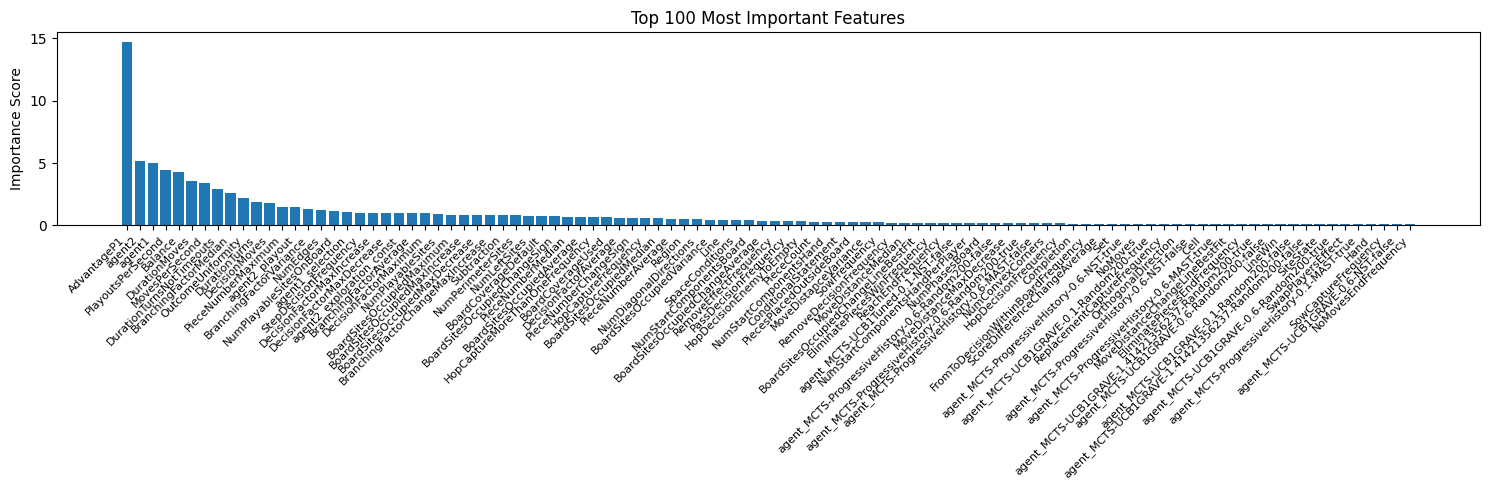

Fold 4 - RMSE: 0.42273042709136754
Fold 5


0:	learn: 0.6048235	test: 0.5794136	best: 0.5794136 (0)	total: 69.1ms	remaining: 3m 27s


50:	learn: 0.3941900	test: 0.4724634	best: 0.4724634 (50)	total: 3.74s	remaining: 3m 36s


100:	learn: 0.3581127	test: 0.4521553	best: 0.4521553 (100)	total: 7.57s	remaining: 3m 37s


150:	learn: 0.3389435	test: 0.4432655	best: 0.4432655 (150)	total: 11.4s	remaining: 3m 35s


200:	learn: 0.3249442	test: 0.4376611	best: 0.4376611 (200)	total: 15.3s	remaining: 3m 33s


250:	learn: 0.3145058	test: 0.4346092	best: 0.4345885 (247)	total: 19.2s	remaining: 3m 30s


300:	learn: 0.3061882	test: 0.4323199	best: 0.4323199 (300)	total: 23s	remaining: 3m 26s


350:	learn: 0.2989198	test: 0.4302792	best: 0.4302792 (350)	total: 27s	remaining: 3m 23s


400:	learn: 0.2926972	test: 0.4286120	best: 0.4286120 (400)	total: 30.9s	remaining: 3m 20s


450:	learn: 0.2872154	test: 0.4277211	best: 0.4277211 (450)	total: 34.8s	remaining: 3m 16s


500:	learn: 0.2819724	test: 0.4265056	best: 0.4264642 (497)	total: 38.8s	remaining: 3m 13s


550:	learn: 0.2772183	test: 0.4254092	best: 0.4253999 (549)	total: 42.6s	remaining: 3m 9s


600:	learn: 0.2728702	test: 0.4247978	best: 0.4247978 (600)	total: 46.5s	remaining: 3m 5s


650:	learn: 0.2690581	test: 0.4240155	best: 0.4239891 (640)	total: 50.5s	remaining: 3m 2s


700:	learn: 0.2656485	test: 0.4235741	best: 0.4235720 (699)	total: 54.4s	remaining: 2m 58s


750:	learn: 0.2624328	test: 0.4230624	best: 0.4230555 (749)	total: 58.4s	remaining: 2m 54s


800:	learn: 0.2591875	test: 0.4226171	best: 0.4225960 (798)	total: 1m 2s	remaining: 2m 50s


850:	learn: 0.2561276	test: 0.4221325	best: 0.4221325 (850)	total: 1m 6s	remaining: 2m 47s


900:	learn: 0.2532976	test: 0.4218835	best: 0.4218684 (896)	total: 1m 10s	remaining: 2m 43s


950:	learn: 0.2506920	test: 0.4218918	best: 0.4218684 (896)	total: 1m 14s	remaining: 2m 39s


1000:	learn: 0.2480907	test: 0.4216032	best: 0.4216032 (1000)	total: 1m 18s	remaining: 2m 35s


1050:	learn: 0.2456263	test: 0.4214113	best: 0.4214032 (1049)	total: 1m 22s	remaining: 2m 32s


1100:	learn: 0.2431931	test: 0.4211290	best: 0.4211290 (1100)	total: 1m 25s	remaining: 2m 28s


1150:	learn: 0.2409654	test: 0.4208007	best: 0.4208007 (1150)	total: 1m 29s	remaining: 2m 24s


1200:	learn: 0.2388290	test: 0.4206495	best: 0.4206376 (1189)	total: 1m 33s	remaining: 2m 20s


1250:	learn: 0.2367709	test: 0.4204729	best: 0.4204569 (1241)	total: 1m 37s	remaining: 2m 16s


1300:	learn: 0.2347783	test: 0.4204094	best: 0.4203938 (1297)	total: 1m 41s	remaining: 2m 13s


1350:	learn: 0.2328238	test: 0.4203246	best: 0.4203114 (1343)	total: 1m 45s	remaining: 2m 9s


1400:	learn: 0.2308603	test: 0.4200687	best: 0.4200573 (1396)	total: 1m 49s	remaining: 2m 5s


1450:	learn: 0.2288320	test: 0.4199500	best: 0.4199477 (1449)	total: 1m 53s	remaining: 2m 1s


1500:	learn: 0.2268392	test: 0.4197819	best: 0.4197708 (1497)	total: 1m 57s	remaining: 1m 57s


1550:	learn: 0.2250820	test: 0.4197180	best: 0.4197129 (1549)	total: 2m 1s	remaining: 1m 53s


1600:	learn: 0.2233783	test: 0.4195725	best: 0.4195725 (1600)	total: 2m 5s	remaining: 1m 49s


1650:	learn: 0.2217814	test: 0.4195904	best: 0.4195595 (1610)	total: 2m 9s	remaining: 1m 45s


1700:	learn: 0.2200767	test: 0.4195144	best: 0.4195144 (1700)	total: 2m 13s	remaining: 1m 42s


1750:	learn: 0.2183938	test: 0.4194075	best: 0.4194060 (1746)	total: 2m 17s	remaining: 1m 38s


1800:	learn: 0.2166805	test: 0.4193473	best: 0.4193402 (1771)	total: 2m 21s	remaining: 1m 34s


1850:	learn: 0.2150966	test: 0.4193197	best: 0.4192998 (1846)	total: 2m 25s	remaining: 1m 30s


1900:	learn: 0.2135248	test: 0.4192353	best: 0.4192353 (1900)	total: 2m 29s	remaining: 1m 26s


1950:	learn: 0.2120069	test: 0.4191697	best: 0.4191346 (1942)	total: 2m 33s	remaining: 1m 22s


2000:	learn: 0.2104597	test: 0.4190850	best: 0.4190796 (1998)	total: 2m 37s	remaining: 1m 18s


2050:	learn: 0.2090100	test: 0.4189887	best: 0.4189871 (2049)	total: 2m 41s	remaining: 1m 14s


2100:	learn: 0.2075528	test: 0.4189251	best: 0.4188897 (2081)	total: 2m 45s	remaining: 1m 10s


2150:	learn: 0.2062353	test: 0.4189639	best: 0.4188829 (2121)	total: 2m 49s	remaining: 1m 6s


2200:	learn: 0.2047964	test: 0.4189251	best: 0.4188829 (2121)	total: 2m 53s	remaining: 1m 2s


2250:	learn: 0.2034717	test: 0.4189162	best: 0.4188823 (2234)	total: 2m 57s	remaining: 58.9s


2300:	learn: 0.2021910	test: 0.4188900	best: 0.4188468 (2261)	total: 3m 1s	remaining: 55s


2350:	learn: 0.2009696	test: 0.4188145	best: 0.4188019 (2343)	total: 3m 5s	remaining: 51.1s


2400:	learn: 0.1995861	test: 0.4187338	best: 0.4187198 (2397)	total: 3m 9s	remaining: 47.2s


2450:	learn: 0.1982894	test: 0.4188106	best: 0.4187198 (2397)	total: 3m 13s	remaining: 43.2s


2500:	learn: 0.1969262	test: 0.4187830	best: 0.4187198 (2397)	total: 3m 16s	remaining: 39.3s


2550:	learn: 0.1957685	test: 0.4187059	best: 0.4186877 (2536)	total: 3m 20s	remaining: 35.4s


2600:	learn: 0.1945159	test: 0.4186625	best: 0.4186518 (2595)	total: 3m 24s	remaining: 31.4s


2650:	learn: 0.1933471	test: 0.4185448	best: 0.4185407 (2649)	total: 3m 28s	remaining: 27.5s


2700:	learn: 0.1920908	test: 0.4185220	best: 0.4185009 (2680)	total: 3m 32s	remaining: 23.6s


2750:	learn: 0.1909073	test: 0.4185084	best: 0.4185009 (2680)	total: 3m 36s	remaining: 19.6s


2800:	learn: 0.1897547	test: 0.4185073	best: 0.4184808 (2785)	total: 3m 40s	remaining: 15.7s


2850:	learn: 0.1886724	test: 0.4185107	best: 0.4184808 (2785)	total: 3m 44s	remaining: 11.7s


2900:	learn: 0.1875941	test: 0.4184438	best: 0.4184363 (2871)	total: 3m 48s	remaining: 7.8s


2950:	learn: 0.1864552	test: 0.4184567	best: 0.4184363 (2871)	total: 3m 52s	remaining: 3.86s


2999:	learn: 0.1853397	test: 0.4184622	best: 0.4184324 (2974)	total: 3m 56s	remaining: 0us

bestTest = 0.4184324499
bestIteration = 2974

Shrink model to first 2975 iterations.


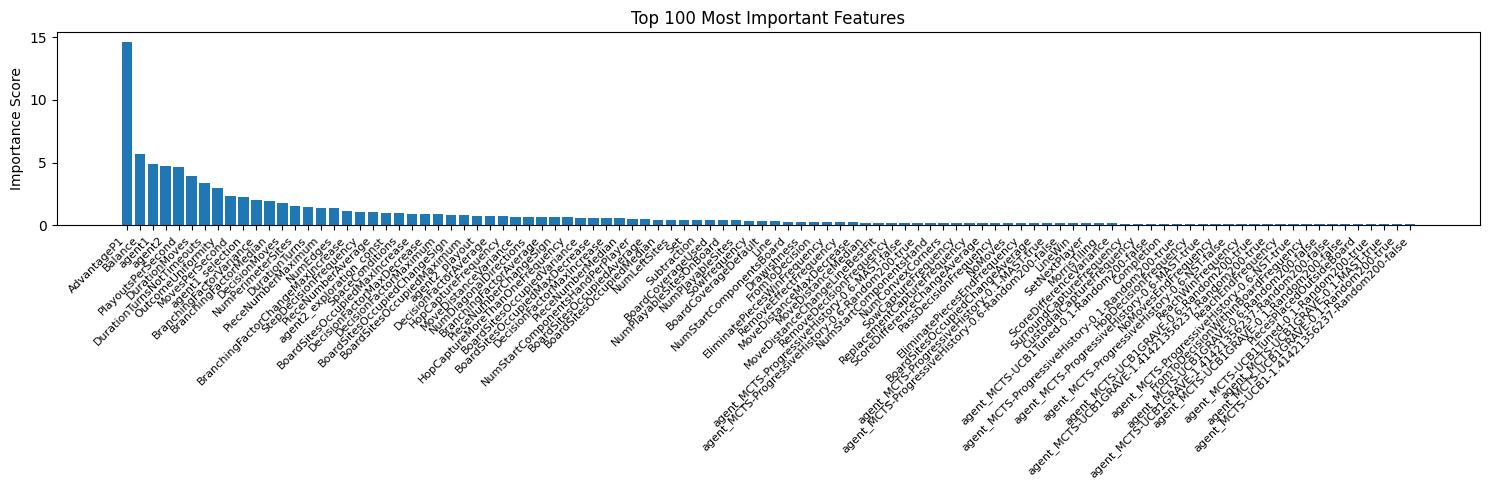

Fold 5 - RMSE: 0.41794252249516056
List of oof scores: [0.4279658345933993, 0.4086844461740019, 0.4190443619477514, 0.42273042709136754, 0.41794252249516056]
Average oof score: 0.41927351846033617


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4248
Score: 0.4383
Score: 0.4188
Score: 0.4340
Score: 0.4051
Average CV1 Score: 0.4242

CV2 OOF Scores:
Score: 0.4052
Score: 0.3981
Score: 0.4238
Score: 0.4354
Score: 0.4245
Average CV2 Score: 0.4174

CV3 OOF Scores:
Score: 0.4280
Score: 0.4087
Score: 0.4190
Score: 0.4227
Score: 0.4179
Average CV3 Score: 0.4193


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

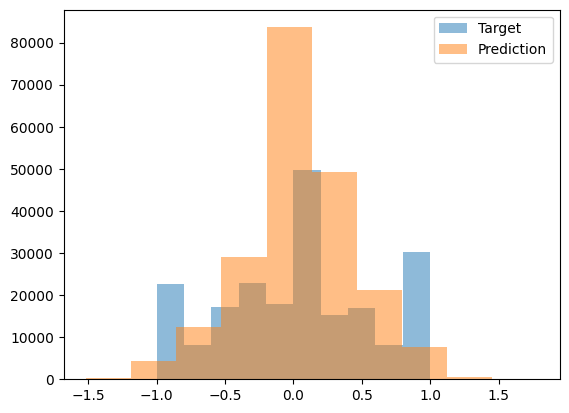

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.142962       │
│ 233235 ┆ -0.126951      │
│ 233236 ┆ -0.021469      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***